# Prepossesing data

## Import data

In [27]:
len(df['permno'].unique())

194

In [1]:
# We wish to first only look at one stock. We wish to find the "best model" for the one stock. 
# Parameters we take into account are: Numbers of lagged values as input (we choose 12), num_nodes, optimizer, batch_size, 3X kernal, dropout, and batch size.
# we will look at exxon corp (permno = 11850)
# First we wish to find the optimal hyperparameters for the model.
# We will use a grid search to find the optimal hyperparameters. (this code will loop though a large grid of parameters and return the best parameters)

import sqlite3
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dropout
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.models import load_model
# Connect to SQLite database
conn = sqlite3.connect("/Users/jensknudsen/Desktop/Seminar/tidy_finance_ML.sqlite")

# Create a pandas DataFrame from the "crsp_monthly" table in the SQLite database
crsp_monthly = pd.read_sql_query("SELECT permno, month, ret_excess, mktcap_lag, sic2, macro_dp, macro_bm, macro_ntis, macro_tbl, characteristic_mom1m, characteristic_mvel1, characteristic_mom12m, characteristic_chmom, characteristic_maxret FROM stock_characteristics_monthly", conn)

# define a function to convert the number of days to a datetime object
def convert_days_to_datetime(num_days):
    start_date = datetime.datetime(1960, 1, 1)
    delta = datetime.timedelta(days=num_days)
    return start_date + delta

# apply the function to the 'date' column to convert it to datetime
crsp_monthly['month'] = crsp_monthly['month'].apply(convert_days_to_datetime)
crsp_monthly

# Select only the stocks that have 708 observations
df = crsp_monthly.query('month >= "1960-01-01"') \
                   .groupby('permno') \
                   .filter(lambda x: len(x) >= 611)

# Count the number of unique stocks in the DataFrame
num_stocks = len(df['permno'].unique())

# make a function that findt the first day of the closest month
def get_closest_first_day(date):
    year = date.year
    month = date.month
    day = date.day
    if day > 15:
        if month == 12:
            month = 1
            year += 1
        else:
            month += 1
    return datetime.datetime(year, month, 1)
# apply the get_closest_first_day function to the month column to get the closest first day of the month
df['date'] = df['month'].apply(get_closest_first_day)

# reorder the columns in the dataframe with 'date' as the first column
df = df[['date'] + [ col for col in df.columns if col != 'date' ]]

# reset the index of the dataframe
df = df.reset_index(drop=True)

# change the datatype of permno column to integer
df['permno'] = df['permno'].astype(int)

# subset the dataframe for the permno 11850
df_first = df[df['permno'] == 11850]
# drop the columns permno, month, and sic2 from the subsetted dataframe
df_first = df_first.drop('permno', axis=1)
df_first = df_first.drop('month', axis=1)
df_first = df_first.drop('sic2', axis=1)
# shift all columns from the 4th column onwards by 1 row to create a lag variable
df_first.iloc[:, 3:] = df_first.iloc[:, 3:].shift(periods=1)
# remove the first row of the dataframe
df_first = df_first.iloc[1:]
# calculate the first difference between each of the rows for all columns from the 3rd column onwards to make the input variables stationary
df_first.iloc[:, 2:] = df_first.diff().iloc[:, 2:]
# create a lagged variable for the 'mktcap_lag' column by taking the first difference between each of the rows
df_first['mktcap_lag'] = df_first['mktcap_lag'].diff()
# remove the first row of the dataframe
df_first = df_first.iloc[2:]
# Check if the data is in the correct format
if df_first.isnull().values.any():    # Checking if the DataFrame 'df_first' contains any null values
    raise ValueError('Data contains null values')   # Raising an error if the DataFrame contains any null values
if not all([col in df_first.columns for col in ['date', 'ret_excess']]):   # Checking if the DataFrame 'df_first' contains the required columns
    raise ValueError('Data is not in the correct format. Expected columns: Time, Returns')   # Raising an error if the DataFrame doesn't contain the required columns
# Preprocess the data
scaler = StandardScaler()   # Creating a StandardScaler object for scaling the data
df_first.iloc[:, 2:] = scaler.fit_transform(df_first.iloc[:, 2:]) 

df_first = df_first.reset_index(drop=True)

In [2]:
df_first

,date,ret_excess,mktcap_lag,macro_dp,macro_bm,macro_ntis,macro_tbl,characteristic_mom1m,characteristic_mvel1,characteristic_mom12m,characteristic_chmom,characteristic_maxret
0,1960-04-01,-0.068319,0.042799,0.016016,0.744689,0.012421,-1.079873,-0.136881,0.210975,-1.539655,0.074680,3.440565
1,1960-05-01,0.069758,-0.083194,2.167841,1.681372,-0.017269,-0.239741,2.274344,3.249850,-1.508197,1.135915,-3.099950
2,1960-06-01,-0.041042,0.082958,1.454186,1.362057,0.771846,0.755151,-0.064981,0.096658,1.247111,2.753302,-0.596716
3,1960-07-01,0.127220,-0.061853,1.195390,0.708089,0.946369,-0.328176,0.492939,0.092513,0.706593,1.382249,0.753881
4,1960-08-01,0.071716,0.113444,-1.532312,-1.926864,0.216652,-0.482937,-1.207702,0.084467,1.936464,-0.568224,-0.444295
...,...,...,...,...,...,...,...,...,...,...,...,...
603,2010-07-01,-0.059134,0.063899,-0.369392,-0.132577,-0.465522,0.091889,-1.632285,-3.805654,0.553862,-0.717893,-0.257203
604,2010-08-01,-0.030281,-0.435061,-1.277754,-0.191533,1.258377,-0.040763,-0.105580,-2.318967,-0.536927,0.010721,0.738417
605,2010-09-01,-0.140561,0.115957,-1.592937,-0.613426,0.911646,-0.040763,-0.229132,-6.054536,-0.419699,0.389033,-1.030810
606,2010-10-01,-0.049911,-0.799354,0.814160,0.221028,0.735165,0.047672,0.057646,-4.731525,-0.441660,0.484642,-1.126702


## Inspections

### inspect the original data to see if it has a gaussian distribution:

In [23]:
df_first# We wish to first only look at one stock. We wish to find the "best model" for the one stock. 
# Parameters we take into account are: Numbers of lagged values as input (we choose 12), num_nodes, optimizer, batch_size, 3X kernal, dropout, and batch size.
# we will look at exxon corp (permno = 11850)
# First we wish to find the optimal hyperparameters for the model.
# We will use a grid search to find the optimal hyperparameters. (this code will loop though a large grid of parameters and return the best parameters)

import sqlite3
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dropout
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.models import load_model
# Connect to SQLite database
conn = sqlite3.connect("/Users/jensknudsen/Desktop/Seminar/tidy_finance_ML.sqlite")

# Create a pandas DataFrame from the "crsp_monthly" table in the SQLite database
crsp_monthly = pd.read_sql_query("SELECT permno, month, ret_excess, mktcap_lag, sic2, macro_dp, macro_bm, macro_ntis, macro_tbl, characteristic_mom1m, characteristic_mvel1, characteristic_mom12m, characteristic_chmom, characteristic_maxret FROM stock_characteristics_monthly", conn)

# define a function to convert the number of days to a datetime object
def convert_days_to_datetime(num_days):
    start_date = datetime.datetime(1960, 1, 1)
    delta = datetime.timedelta(days=num_days)
    return start_date + delta

# apply the function to the 'date' column to convert it to datetime
crsp_monthly['month'] = crsp_monthly['month'].apply(convert_days_to_datetime)
crsp_monthly

# Select only the stocks that have 708 observations
df = crsp_monthly.query('month >= "1960-01-01"') \
                   .groupby('permno') \
                   .filter(lambda x: len(x) >= 611)

# Count the number of unique stocks in the DataFrame
num_stocks = len(df['permno'].unique())

# make a function that findt the first day of the closest month
def get_closest_first_day(date):
    year = date.year
    month = date.month
    day = date.day
    if day > 15:
        if month == 12:
            month = 1
            year += 1
        else:
            month += 1
    return datetime.datetime(year, month, 1)
# apply the get_closest_first_day function to the month column to get the closest first day of the month
df['date'] = df['month'].apply(get_closest_first_day)

# reorder the columns in the dataframe with 'date' as the first column
df = df[['date'] + [ col for col in df.columns if col != 'date' ]]

# reset the index of the dataframe
df = df.reset_index(drop=True)

# change the datatype of permno column to integer
df['permno'] = df['permno'].astype(int)

# subset the dataframe for the permno 11850
df_first = df[df['permno'] == 11850]
# drop the columns permno, month, and sic2 from the subsetted dataframe
df_first = df_first.drop('permno', axis=1)
df_first = df_first.drop('month', axis=1)
df_first = df_first.drop('sic2', axis=1)
# shift all columns from the 4th column onwards by 1 row to create a lag variable
df_first.iloc[:, 3:] = df_first.iloc[:, 3:].shift(periods=1)
# remove the first row of the dataframe
df_first = df_first.iloc[1:]
# calculate the first difference between each of the rows for all columns from the 3rd column onwards to make the input variables stationary
df_first.iloc[:, 2:] = df_first.diff().iloc[:, 2:]
# create a lagged variable for the 'mktcap_lag' column by taking the first difference between each of the rows
df_first['mktcap_lag'] = df_first['mktcap_lag'].diff()
# remove the first row of the dataframe
df_first = df_first.iloc[2:]
# Check if the data is in the correct format
if df_first.isnull().values.any():    # Checking if the DataFrame 'df_first' contains any null values
    raise ValueError('Data contains null values')   # Raising an error if the DataFrame contains any null values
if not all([col in df_first.columns for col in ['date', 'ret_excess']]):   # Checking if the DataFrame 'df_first' contains the required columns
    raise ValueError('Data is not in the correct format. Expected columns: Time, Returns')   # Raising an error if the DataFrame doesn't contain the required columns
# Preprocess the data

<Axes: xlabel='ret_excess', ylabel='Count'>

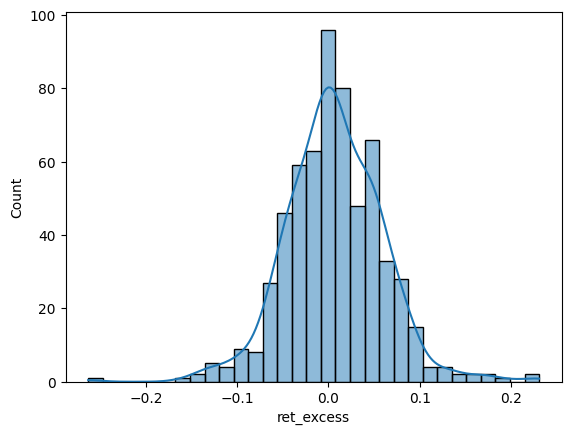

In [21]:
# plot the characteristic_mvel1 in a histrogram in sns:
sns.histplot(df_first['ret_excess'], kde=True)

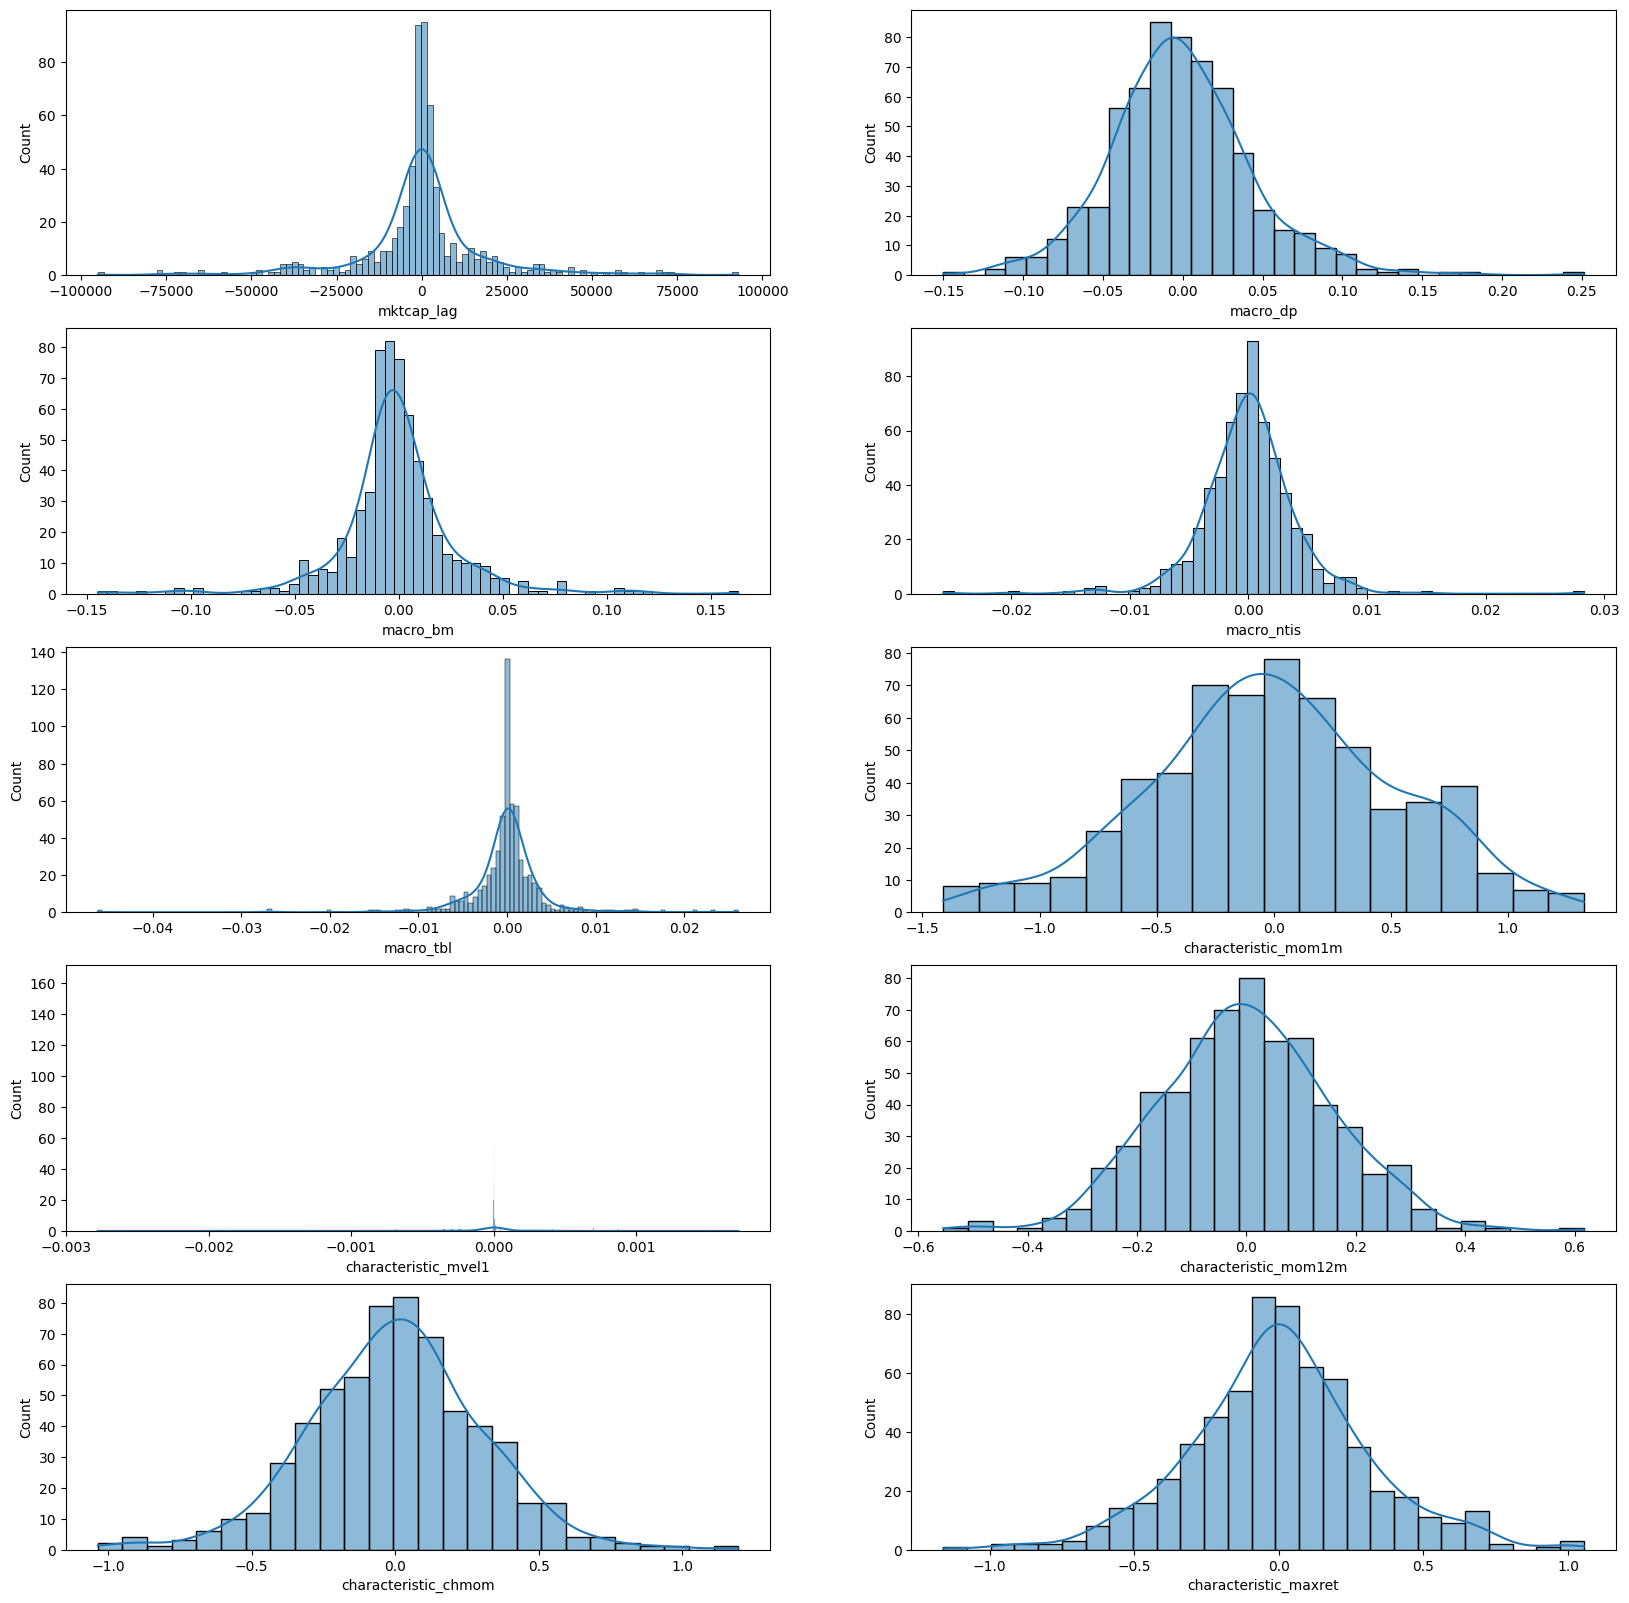

In [18]:
# combine all the plots above into one plot:
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
sns.histplot(df_first['mktcap_lag'], kde=True, ax=axs[0, 0])
sns.histplot(df_first['macro_dp'], kde=True, ax=axs[0, 1])
sns.histplot(df_first['macro_bm'], kde=True, ax=axs[1, 0])
sns.histplot(df_first['macro_ntis'], kde=True, ax=axs[1, 1])
sns.histplot(df_first['macro_tbl'], kde=True, ax=axs[2, 0])
sns.histplot(df_first['characteristic_mom1m'], kde=True, ax=axs[2, 1])
sns.histplot(df_first['characteristic_mvel1'], kde=True, ax=axs[3, 0])
sns.histplot(df_first['characteristic_mom12m'], kde=True, ax=axs[3, 1])
sns.histplot(df_first['characteristic_chmom'], kde=True, ax=axs[4, 0])
sns.histplot(df_first['characteristic_maxret'], kde=True, ax=axs[4, 1])
plt.show()

### Normality test

In [ ]:
# We wish to first only look at one stock. We wish to find the "best model" for the one stock. 
# Parameters we take into account are: Numbers of lagged values as input (we choose 12), num_nodes, optimizer, batch_size, 3X kernal, dropout, and batch size.
# we will look at exxon corp (permno = 11850)
# First we wish to find the optimal hyperparameters for the model.
# We will use a grid search to find the optimal hyperparameters. (this code will loop though a large grid of parameters and return the best parameters)

import sqlite3
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dropout
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.models import load_model
# Connect to SQLite database
conn = sqlite3.connect("/Users/jensknudsen/Desktop/Seminar/tidy_finance_ML.sqlite")

# Create a pandas DataFrame from the "crsp_monthly" table in the SQLite database
crsp_monthly = pd.read_sql_query("SELECT permno, month, ret_excess, mktcap_lag, sic2, macro_dp, macro_bm, macro_ntis, macro_tbl, characteristic_mom1m, characteristic_mvel1, characteristic_mom12m, characteristic_chmom, characteristic_maxret FROM stock_characteristics_monthly", conn)

# define a function to convert the number of days to a datetime object
def convert_days_to_datetime(num_days):
    start_date = datetime.datetime(1960, 1, 1)
    delta = datetime.timedelta(days=num_days)
    return start_date + delta

# apply the function to the 'date' column to convert it to datetime
crsp_monthly['month'] = crsp_monthly['month'].apply(convert_days_to_datetime)
crsp_monthly

# Select only the stocks that have 708 observations
df = crsp_monthly.query('month >= "1960-01-01"') \
                   .groupby('permno') \
                   .filter(lambda x: len(x) >= 611)

# Count the number of unique stocks in the DataFrame
num_stocks = len(df['permno'].unique())

# make a function that findt the first day of the closest month
def get_closest_first_day(date):
    year = date.year
    month = date.month
    day = date.day
    if day > 15:
        if month == 12:
            month = 1
            year += 1
        else:
            month += 1
    return datetime.datetime(year, month, 1)
# apply the get_closest_first_day function to the month column to get the closest first day of the month
df['date'] = df['month'].apply(get_closest_first_day)

# reorder the columns in the dataframe with 'date' as the first column
df = df[['date'] + [ col for col in df.columns if col != 'date' ]]

# reset the index of the dataframe
df = df.reset_index(drop=True)

# change the datatype of permno column to integer
df['permno'] = df['permno'].astype(int)

# subset the dataframe for the permno 11850
df_first = df[df['permno'] == 11850]
# drop the columns permno, month, and sic2 from the subsetted dataframe
df_first = df_first.drop('permno', axis=1)
df_first = df_first.drop('month', axis=1)
df_first = df_first.drop('sic2', axis=1)
# shift all columns from the 4th column onwards by 1 row to create a lag variable
df_first.iloc[:, 3:] = df_first.iloc[:, 3:].shift(periods=1)
# remove the first row of the dataframe
df_first = df_first.iloc[1:]
# calculate the first difference between each of the rows for all columns from the 3rd column onwards to make the input variables stationary
df_first.iloc[:, 2:] = df_first.diff().iloc[:, 2:]
# create a lagged variable for the 'mktcap_lag' column by taking the first difference between each of the rows
df_first['mktcap_lag'] = df_first['mktcap_lag'].diff()
# remove the first row of the dataframe
df_first = df_first.iloc[2:]
# Check if the data is in the correct format
if df_first.isnull().values.any():    # Checking if the DataFrame 'df_first' contains any null values
    raise ValueError('Data contains null values')   # Raising an error if the DataFrame contains any null values
if not all([col in df_first.columns for col in ['date', 'ret_excess']]):   # Checking if the DataFrame 'df_first' contains the required columns
    raise ValueError('Data is not in the correct format. Expected columns: Time, Returns')   # Raising an error if the DataFrame doesn't contain the required columns
# Preprocess the data
scaler = StandardScaler()   # Creating a StandardScaler object for scaling the data
df_first.iloc[:, 2:] = scaler.fit_transform(df_first.iloc[:, 2:]) 

df_first = df_first.reset_index(drop=True)

In [6]:
from scipy.stats import shapiro
import pandas as pd
from scipy import stats
from statsmodels.tsa.stattools import adfuller

In [7]:
for i in df_first.columns[1:]:
    stat, p = stats.normaltest(df_first[i])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print(i, 'looks Gaussian (fail to reject H0)')
    else:
        print(i, 'Data does not look Gaussian (reject H0)')

Statistics=34.436, p=0.000
ret_excess Data does not look Gaussian (reject H0)
Statistics=84.855, p=0.000
mktcap_lag Data does not look Gaussian (reject H0)
Statistics=67.433, p=0.000
macro_dp Data does not look Gaussian (reject H0)
Statistics=96.974, p=0.000
macro_bm Data does not look Gaussian (reject H0)
Statistics=117.492, p=0.000
macro_ntis Data does not look Gaussian (reject H0)
Statistics=345.108, p=0.000
macro_tbl Data does not look Gaussian (reject H0)
Statistics=1.316, p=0.518
characteristic_mom1m looks Gaussian (fail to reject H0)
Statistics=459.727, p=0.000
characteristic_mvel1 Data does not look Gaussian (reject H0)
Statistics=4.979, p=0.083
characteristic_mom12m looks Gaussian (fail to reject H0)
Statistics=12.020, p=0.002
characteristic_chmom Data does not look Gaussian (reject H0)
Statistics=11.754, p=0.003
characteristic_maxret Data does not look Gaussian (reject H0)


### Stationary test:

In [8]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

for i in df_first.columns[1:]:
    # Apply the ADF test to the 'values' column
    result = adfuller(df_first[i])

    # Extract the test statistic and p-value from the test result
    test_statistic = result[0]
    p_value = result[1]
    if p_value < 0.05:
        print(i, 'is stationary')
    else:
        print(i, 'is non-stationary')


ret_excess is stationary
mktcap_lag is stationary
macro_dp is stationary
macro_bm is stationary
macro_ntis is stationary
macro_tbl is stationary
characteristic_mom1m is stationary
characteristic_mvel1 is non-stationary
characteristic_mom12m is stationary
characteristic_chmom is stationary
characteristic_maxret is stationary


### Plot 

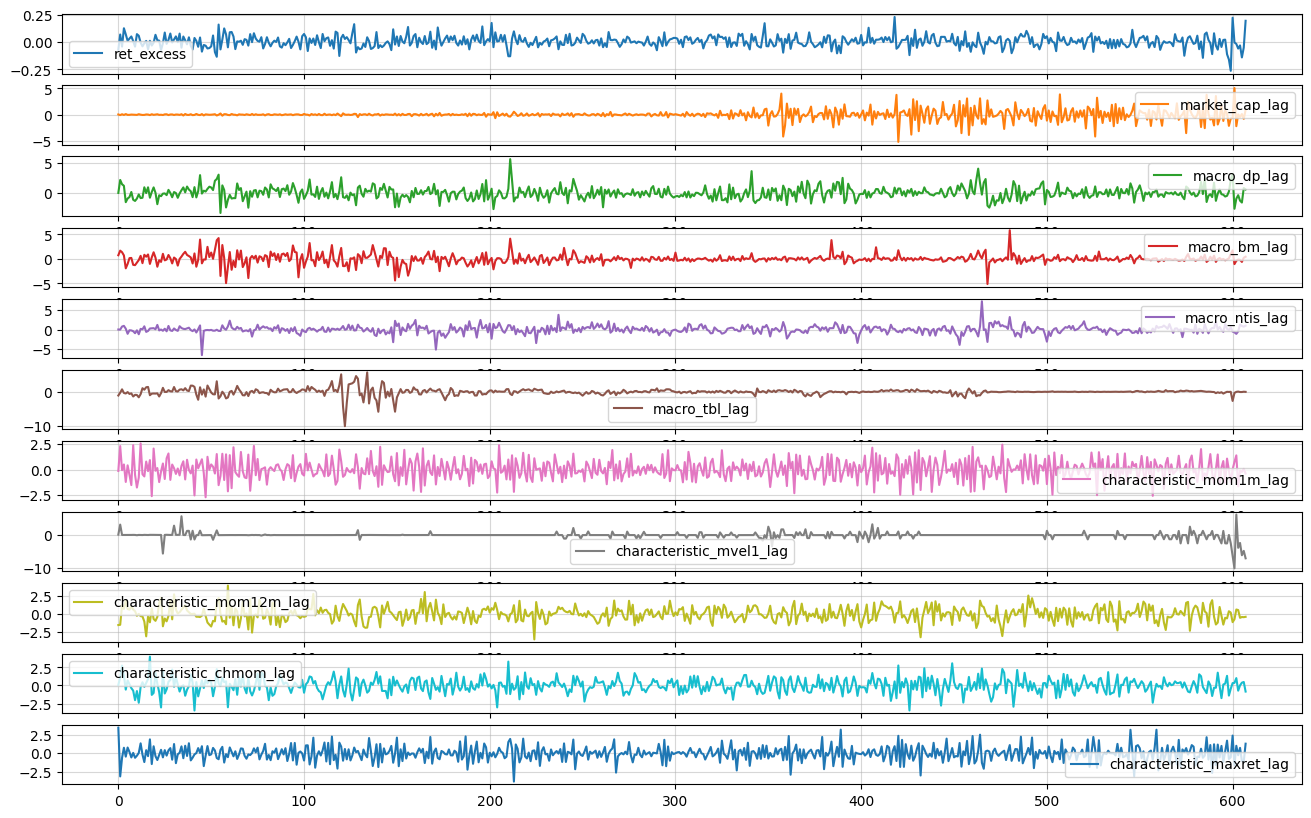

In [9]:
fig, ax = plt.subplots(11,1, figsize = (16,10))
ax[0].plot(df_first["ret_excess"],label="ret_excess",color="C0")
ax[1].plot(df_first["mktcap_lag"], label="market_cap_lag",color="C1")
ax[2].plot(df_first["macro_dp"], label="macro_dp_lag",color="C2")
ax[3].plot(df_first["macro_bm"], label="macro_bm_lag",color="C3")
ax[4].plot(df_first["macro_ntis"], label="macro_ntis_lag",color="C4")
ax[5].plot(df_first["macro_tbl"], label="macro_tbl_lag",color="C5")
ax[6].plot(df_first["characteristic_mom1m"], label="characteristic_mom1m_lag",color="C6")
ax[7].plot(df_first["characteristic_mvel1"], label="characteristic_mvel1_lag",color="C7")
ax[8].plot(df_first["characteristic_mom12m"], label="characteristic_mom12m_lag",color="C8")
ax[9].plot(df_first["characteristic_chmom"], label="characteristic_chmom_lag",color="C9")
ax[10].plot(df_first["characteristic_maxret"], label="characteristic_maxret_lag",color="C10")
[a.grid(alpha=0.5) for a in ax]
[a.legend() for a in ax]

# Model

## LSTM - FIND THE BEST MODEL

In [1]:
# We wish to first only look at one stock. We wish to find the "best model" for the one stock. 
# Parameters we take into account are: Numbers of lagged values as input (we choose 12), num_nodes, optimizer, batch_size, 3X kernal, dropout, and batch size.
# we will look at exxon corp (permno = 11850)
# First we wish to find the optimal hyperparameters for the model.
# We will use a grid search to find the optimal hyperparameters. (this code will loop though a large grid of parameters and return the best parameters)

import sqlite3
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dropout
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.models import load_model
# Connect to SQLite database
conn = sqlite3.connect("/Users/jensknudsen/Desktop/Seminar/tidy_finance_ML.sqlite")

# Create a pandas DataFrame from the "crsp_monthly" table in the SQLite database
crsp_monthly = pd.read_sql_query("SELECT permno, month, ret_excess, mktcap_lag, sic2, macro_dp, macro_bm, macro_ntis, macro_tbl, characteristic_mom1m, characteristic_mvel1, characteristic_mom12m, characteristic_chmom, characteristic_maxret FROM stock_characteristics_monthly", conn)

# define a function to convert the number of days to a datetime object
def convert_days_to_datetime(num_days):
    start_date = datetime.datetime(1960, 1, 1)
    delta = datetime.timedelta(days=num_days)
    return start_date + delta

# apply the function to the 'date' column to convert it to datetime
crsp_monthly['month'] = crsp_monthly['month'].apply(convert_days_to_datetime)
crsp_monthly

# Select only the stocks that have 708 observations
df = crsp_monthly.query('month >= "1960-01-01"') \
                   .groupby('permno') \
                   .filter(lambda x: len(x) >= 611)

# Count the number of unique stocks in the DataFrame
num_stocks = len(df['permno'].unique())

# make a function that findt the first day of the closest month
def get_closest_first_day(date):
    year = date.year
    month = date.month
    day = date.day
    if day > 15:
        if month == 12:
            month = 1
            year += 1
        else:
            month += 1
    return datetime.datetime(year, month, 1)
# apply the get_closest_first_day function to the month column to get the closest first day of the month
df['date'] = df['month'].apply(get_closest_first_day)

# reorder the columns in the dataframe with 'date' as the first column
df = df[['date'] + [ col for col in df.columns if col != 'date' ]]

# reset the index of the dataframe
df = df.reset_index(drop=True)

# change the datatype of permno column to integer
df['permno'] = df['permno'].astype(int)

# subset the dataframe for the permno 11850
df_first = df[df['permno'] == 11850]
# drop the columns permno, month, and sic2 from the subsetted dataframe
df_first = df_first.drop('permno', axis=1)
df_first = df_first.drop('month', axis=1)
df_first = df_first.drop('sic2', axis=1)
# shift all columns from the 4th column onwards by 1 row to create a lag variable
df_first.iloc[:, 3:] = df_first.iloc[:, 3:].shift(periods=1)
# remove the first row of the dataframe
df_first = df_first.iloc[1:]
# calculate the first difference between each of the rows for all columns from the 3rd column onwards to make the input variables stationary
df_first.iloc[:, 2:] = df_first.diff().iloc[:, 2:]
# create a lagged variable for the 'mktcap_lag' column by taking the first difference between each of the rows
df_first['mktcap_lag'] = df_first['mktcap_lag'].diff()
# remove the first row of the dataframe
df_first = df_first.iloc[2:]
# Check if the data is in the correct format
if df_first.isnull().values.any():    # Checking if the DataFrame 'df_first' contains any null values
    raise ValueError('Data contains null values')   # Raising an error if the DataFrame contains any null values
if not all([col in df_first.columns for col in ['date', 'ret_excess']]):   # Checking if the DataFrame 'df_first' contains the required columns
    raise ValueError('Data is not in the correct format. Expected columns: Time, Returns')   # Raising an error if the DataFrame doesn't contain the required columns
# Preprocess the data
scaler = StandardScaler()   # Creating a StandardScaler object for scaling the data
df_first.iloc[:, 2:] = scaler.fit_transform(df_first.iloc[:, 2:])   # Scaling the numerical data in the DataFrame 'df_first'
X = df_first.iloc[:, 2:].values   # Extracting the feature data from the DataFrame 'df_first'
y = df_first.iloc[:, 1].values    # Extracting the target data from the DataFrame 'df_first'
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)   # Splitting the data into training and testing sets with a test size of 0.2
# Reshape the data for LSTM
# Reshaping the input data to be of shape so that it can be fed into the LSTM model
lookback_periods = 12
X_train_list = []
X_test_list = []
for i in range(lookback_periods, X_train.shape[0]):
    X_train_list.append(X_train[i-lookback_periods:i, :])
for i in range(lookback_periods, X_test.shape[0]):
    X_test_list.append(X_test[i-lookback_periods:i, :])
X_train = np.array(X_train_list)
X_test = np.array(X_test_list)
X_train = X_train.reshape(X_train.shape[0], lookback_periods, X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], lookback_periods, X_test.shape[2])
y_train = np.delete(y_train, list(range(-1, lookback_periods-1)))
y_test = np.delete(y_test, list(range(-1, lookback_periods-1)))

In [1]:
# We wish to first only look at one stock. We wish to find the "best model" for the one stock. 
# Parameters we take into account are: Numbers of lagged values as input (we choose 12), num_nodes, optimizer, batch_size, 3X kernal, dropout, and batch size.
# we will look at exxon corp (permno = 11850)
# First we wish to find the optimal hyperparameters for the model.
# We will use a grid search to find the optimal hyperparameters. (this code will loop though a large grid of parameters and return the best parameters)

import sqlite3
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dropout
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.models import load_model
# Connect to SQLite database
conn = sqlite3.connect("/Users/jensknudsen/Desktop/Seminar/tidy_finance_ML.sqlite")

# Create a pandas DataFrame from the "crsp_monthly" table in the SQLite database
crsp_monthly = pd.read_sql_query("SELECT permno, month, ret_excess, mktcap_lag, sic2, macro_dp, macro_bm, macro_ntis, macro_tbl, characteristic_mom1m, characteristic_mvel1, characteristic_mom12m, characteristic_chmom, characteristic_maxret FROM stock_characteristics_monthly", conn)

# define a function to convert the number of days to a datetime object
def convert_days_to_datetime(num_days):
    start_date = datetime.datetime(1960, 1, 1)
    delta = datetime.timedelta(days=num_days)
    return start_date + delta

# apply the function to the 'date' column to convert it to datetime
crsp_monthly['month'] = crsp_monthly['month'].apply(convert_days_to_datetime)
crsp_monthly

# Select only the stocks that have 708 observations
df = crsp_monthly.query('month >= "1960-01-01"') \
                   .groupby('permno') \
                   .filter(lambda x: len(x) >= 611)

# Count the number of unique stocks in the DataFrame
num_stocks = len(df['permno'].unique())

# make a function that findt the first day of the closest month
def get_closest_first_day(date):
    year = date.year
    month = date.month
    day = date.day
    if day > 15:
        if month == 12:
            month = 1
            year += 1
        else:
            month += 1
    return datetime.datetime(year, month, 1)
# apply the get_closest_first_day function to the month column to get the closest first day of the month
df['date'] = df['month'].apply(get_closest_first_day)

# reorder the columns in the dataframe with 'date' as the first column
df = df[['date'] + [ col for col in df.columns if col != 'date' ]]

# reset the index of the dataframe
df = df.reset_index(drop=True)

# change the datatype of permno column to integer
df['permno'] = df['permno'].astype(int)

# subset the dataframe for the permno 11850
df_first = df[df['permno'] == 11850]
# drop the columns permno, month, and sic2 from the subsetted dataframe
df_first = df_first.drop('permno', axis=1)
df_first = df_first.drop('month', axis=1)
df_first = df_first.drop('sic2', axis=1)
# shift all columns from the 4th column onwards by 1 row to create a lag variable
df_first.iloc[:, 3:] = df_first.iloc[:, 3:].shift(periods=1)
# remove the first row of the dataframe
df_first = df_first.iloc[1:]
# calculate the first difference between each of the rows for all columns from the 3rd column onwards to make the input variables stationary
df_first.iloc[:, 2:] = df_first.diff().iloc[:, 2:]
# create a lagged variable for the 'mktcap_lag' column by taking the first difference between each of the rows
df_first['mktcap_lag'] = df_first['mktcap_lag'].diff()
# remove the first row of the dataframe
df_first = df_first.iloc[2:]
# Check if the data is in the correct format
if df_first.isnull().values.any():    # Checking if the DataFrame 'df_first' contains any null values
    raise ValueError('Data contains null values')   # Raising an error if the DataFrame contains any null values
if not all([col in df_first.columns for col in ['date', 'ret_excess']]):   # Checking if the DataFrame 'df_first' contains the required columns
    raise ValueError('Data is not in the correct format. Expected columns: Time, Returns')   # Raising an error if the DataFrame doesn't contain the required columns
# Preprocess the data
scaler = StandardScaler()   # Creating a StandardScaler object for scaling the data
df_first.iloc[:, 2:] = scaler.fit_transform(df_first.iloc[:, 2:])   # Scaling the numerical data in the DataFrame 'df_first'
X = df_first.iloc[:, 2:].values   # Extracting the feature data from the DataFrame 'df_first'
y = df_first.iloc[:, 1].values    # Extracting the target data from the DataFrame 'df_first'
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)   # Splitting the data into training and testing sets with a test size of 0.2
# Reshape the data for LSTM
# Reshaping the input data to be of shape so that it can be fed into the LSTM model
lookback_periods = 12
X_train_list = []
X_test_list = []
for i in range(lookback_periods, X_train.shape[0]):
    X_train_list.append(X_train[i-lookback_periods:i, :])
for i in range(lookback_periods, X_test.shape[0]):
    X_test_list.append(X_test[i-lookback_periods:i, :])
X_train = np.array(X_train_list)
X_test = np.array(X_test_list)
X_train = X_train.reshape(X_train.shape[0], lookback_periods, X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], lookback_periods, X_test.shape[2])
y_train = np.delete(y_train, list(range(-1, lookback_periods-1)))
y_test = np.delete(y_test, list(range(-1, lookback_periods-1)))
    # Define the function to create the LSTM model
def create_model(num_nodes=128, optimizer='adam', kernel_regularizer=0.001, recurrent_regularizer=0.001, bias_regularizer=0.001, dropout=0.2, batch_size=32):
    model = Sequential()
    # Add an LSTM layer with `num_nodes` number of nodes
    # The `input_shape` argument specifies the shape of the input data
    # The `kernel_regularizer`, `recurrent_regularizer`, and `bias_regularizer` arguments add L2 regularization to the kernel, recurrent, and bias weights of the layer, respectively
    model.add(LSTM(num_nodes, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=tf.keras.regularizers.l2(kernel_regularizer), recurrent_regularizer=tf.keras.regularizers.l2(recurrent_regularizer), bias_regularizer=tf.keras.regularizers.l2(bias_regularizer)))
    # Add a dropout layer to the model
    # The `dropout` argument specifies the rate of neurons to be dropped out during training
    model.add(Dropout(dropout))
    # Add a dense layer with 32 nodes and ReLU activation
    model.add(Dense(32, activation='sigmoid')) # maybe use the default activation function sigmoid instead of relu
    # Add a dense output layer with 1 node
    model.add(Dense(1))
    # Compile the model with the mean squared error loss function and the specified optimizer
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model
# Define the grid search parameters
# The `param_grid` dictionary contains the hyperparameters to be searched over in the grid search
param_grid = {
    'num_nodes': [128],
    'optimizer': ['rmsprop'],
    'kernel_regularizer': [0.001,0.01],
    'recurrent_regularizer': [0.001,0.01],
    'bias_regularizer': [0.001,0.01],
    'dropout': [0.2,0.3],
    'batch_size': [64],
}
# Create the KerasRegressor object with the specified hyperparameters and settings
model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model, epochs=100, batch_size=16, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)], shuffle=False)
# Define the time series cross-validation object with 3 splits
tscv = TimeSeriesSplit(n_splits=3)
# Create the GridSearchCV object with the specified hyperparameters and cross-validation object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv)
# Fit the GridSearchCV object to the training data to find the best hyperparameters (setting verbose=0 get the output minimized)
grid_result = grid.fit(X_train, y_train,verbose=0)
# Print the best score and best parameters found by GridSearchCV
print('Best Score: {:.4f}'.format(grid_result.best_score_))
print('Best Parameters: ', grid_result.best_params_)
# Create a new LSTM model with the best hyperparameters found by GridSearchCV
best_model = create_model(**grid_result.best_params_)
# Train the best model on the training data with the same settings as before
best_history = best_model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)], shuffle=False)
# Evaluate the best model on the test data and print the test loss
loss = best_model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {:.4f}'.format(loss))
# Use the best model to make predictions on the test data
y_pred = best_model.predict(X_test, verbose=0)
# Calculate accuracy, precision, and recall
y_pred_direction = np.sign(y_pred[1:] - y_pred[:-1])    # Calculate the predicted direction of stock prices
y_test_direction = np.sign(y_test[1:] - y_test[:-1])    # Calculate the actual direction of stock prices
accuracy = accuracy_score(y_test_direction, y_pred_direction)    # Calculate the accuracy score
precision = precision_score(y_test_direction, y_pred_direction, average='macro')    # Calculate the precision score
recall = recall_score(y_test_direction, y_pred_direction, average='macro')    # Calculate the recall score
# Print the accuracy, precision, and recall scores
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
# Evaluate the best_model
loss = best_model.evaluate(X_test, y_test, verbose=0)    # Evaluate the model on the test data
print('Test Loss: {:.2f}'.format(loss))
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)    # Calculate the mean squared error between the predicted and actual stock prices
print('MSE: {:.6f}'.format(mse))
# Calculate the percentage of times y_pred and y_test move in the same direction
num_same_directions = 0    # Initialize the count for the number of times y_pred and y_test move in the same direction
num_total_movements = len(y_pred) - 1    # Calculate the total number of stock price movements
for i in range(1, len(y_pred)):
    if (y_pred[i] - y_pred[i-1]) * (y_test[i] - y_test[i-1]) > 0:
        num_same_directions += 1
pct_same_directions = num_same_directions / num_total_movements * 100    # Calculate the percentage of times y_pred and y_test move in the same direction
print("Percentage of times y_pred and y_test move in the same direction: {:.2f}%".format(pct_same_directions))

# Plot the predictions
import matplotlib.pyplot as plt
plt.plot(y_test, label='True')    # Plot the actual stock prices
plt.plot(y_pred, label='Predicted')    # Plot the predicted stock prices
plt.legend()    # Add a legend to the plot
plt.show()    # Show the plot
# Plot the training and validation loss over time
plt.plot(best_history.history['loss'], label='Training Loss')    # Plot the training loss
plt.plot(best_history.history['val_loss'], label='Validation Loss')    # Plot the validation loss
plt.xlabel('Epoch')    # Add a label to the x-axis
plt.ylabel('Loss')    # Add a label to the y-axis
plt.legend()    # Add a legend to the plot
plt.show()    # Show the plot
# save model to single file
#best_model.save('best_lstm_model.h5')

/var/folders/73/n7lgj33x23g9bs4jy5z1pgg40000gn/T/ipykernel_63947/3325267738.py:145: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model, epochs=100, batch_size=16, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)], shuffle=False)
2023-04-07 15:11:56.893527: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-07 15:11:56.894116: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-07 15:11:57.180766: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-07 15:11:57.943149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-07 15:11:58.144203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-07 15:11:58.321007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-07 15:11:58.746126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-07 15:11:58.805425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 31ms/step - loss: 0.0842


2023-04-07 15:12:03.219224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-07 15:12:03.383097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-07 15:12:03.498416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-07 15:12:03.869851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-07 15:12:03.928742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 31ms/step - loss: 0.0642


2023-04-07 15:12:09.299866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-07 15:12:09.481890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-07 15:12:09.595684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-07 15:12:10.022638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-07 15:12:10.080302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

## LSTM - GET THE DISTRIBUTION 

In [ ]:
## Run the best model 100 times and append the results to a list:
import sqlite3
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dropout
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.models import load_model
# Connect to SQLite database
conn = sqlite3.connect("/Users/jensknudsen/Desktop/Seminar/tidy_finance_ML.sqlite")

# Create a pandas DataFrame from the "crsp_monthly" table in the SQLite database
crsp_monthly = pd.read_sql_query("SELECT permno, month, ret_excess, mktcap_lag, sic2, macro_dp, macro_bm, macro_ntis, macro_tbl, characteristic_mom1m, characteristic_mvel1, characteristic_mom12m, characteristic_chmom, characteristic_maxret FROM stock_characteristics_monthly", conn)

# define a function to convert the number of days to a datetime object
def convert_days_to_datetime(num_days):
    start_date = datetime.datetime(1960, 1, 1)
    delta = datetime.timedelta(days=num_days)
    return start_date + delta

# apply the function to the 'date' column to convert it to datetime
crsp_monthly['month'] = crsp_monthly['month'].apply(convert_days_to_datetime)
crsp_monthly

# Select only the stocks that have 708 observations
df = crsp_monthly.query('month >= "1960-01-01"') \
                   .groupby('permno') \
                   .filter(lambda x: len(x) >= 611)

# Count the number of unique stocks in the DataFrame
num_stocks = len(df['permno'].unique())

# make a function that findt the first day of the closest month
def get_closest_first_day(date):
    year = date.year
    month = date.month
    day = date.day
    if day > 15:
        if month == 12:
            month = 1
            year += 1
        else:
            month += 1
    return datetime.datetime(year, month, 1)
# apply the get_closest_first_day function to the month column to get the closest first day of the month
df['date'] = df['month'].apply(get_closest_first_day)

# reorder the columns in the dataframe with 'date' as the first column
df = df[['date'] + [ col for col in df.columns if col != 'date' ]]

# reset the index of the dataframe
df = df.reset_index(drop=True)

# change the datatype of permno column to integer
df['permno'] = df['permno'].astype(int)

# make a list containing the number 11850 100 times:
permno_list = [11850] * 5


for i in permno_list:
    # subset the dataframe for the permno 11850
    df_first = df[df['permno'] == 11850]
    # drop the columns permno, month, and sic2 from the subsetted dataframe
    df_first = df_first.drop('permno', axis=1)
    df_first = df_first.drop('month', axis=1)
    df_first = df_first.drop('sic2', axis=1)
    # shift all columns from the 4th column onwards by 1 row to create a lag variable
    df_first.iloc[:, 3:] = df_first.iloc[:, 3:].shift(periods=1)
    # remove the first row of the dataframe
    df_first = df_first.iloc[1:]
    # calculate the first difference between each of the rows for all columns from the 3rd column onwards to make the input variables stationary
    df_first.iloc[:, 2:] = df_first.diff().iloc[:, 2:]
    # create a lagged variable for the 'mktcap_lag' column by taking the first difference between each of the rows
    df_first['mktcap_lag'] = df_first['mktcap_lag'].diff()
    # remove the first row of the dataframe
    df_first = df_first.iloc[2:]
    # Check if the data is in the correct format
    if df_first.isnull().values.any():    # Checking if the DataFrame 'df_first' contains any null values
        raise ValueError('Data contains null values')   # Raising an error if the DataFrame contains any null values
    if not all([col in df_first.columns for col in ['date', 'ret_excess']]):   # Checking if the DataFrame 'df_first' contains the required columns
        raise ValueError('Data is not in the correct format. Expected columns: Time, Returns')   # Raising an error if the DataFrame doesn't contain the required columns
    # Preprocess the data
    scaler = StandardScaler()   # Creating a StandardScaler object for scaling the data
    df_first.iloc[:, 2:] = scaler.fit_transform(df_first.iloc[:, 2:])   # Scaling the numerical data in the DataFrame 'df_first'
    X = df_first.iloc[:, 2:].values   # Extracting the feature data from the DataFrame 'df_first'
    y = df_first.iloc[:, 1].values    # Extracting the target data from the DataFrame 'df_first'
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)   # Splitting the data into training and testing sets with a test size of 0.2
    # Reshape the data for LSTM
    # Reshaping the input data to be of shape so that it can be fed into the LSTM model
    lookback_periods = 12
    X_train_list = []
    X_test_list = []
    for i in range(lookback_periods, X_train.shape[0]):
        X_train_list.append(X_train[i-lookback_periods:i, :])
    for i in range(lookback_periods, X_test.shape[0]):
        X_test_list.append(X_test[i-lookback_periods:i, :])
    X_train = np.array(X_train_list)
    X_test = np.array(X_test_list)
    X_train = X_train.reshape(X_train.shape[0], lookback_periods, X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0], lookback_periods, X_test.shape[2])
    y_train = np.delete(y_train, list(range(-1, lookback_periods-1)))
    y_test = np.delete(y_test, list(range(-1, lookback_periods-1)))
        # Define the function to create the LSTM model
    def create_model(num_nodes=128, optimizer='adam', kernel_regularizer=0.001, recurrent_regularizer=0.001, bias_regularizer=0.001, dropout=0.2, batch_size=32):
        model = Sequential()
        # Add an LSTM layer with `num_nodes` number of nodes
        # The `input_shape` argument specifies the shape of the input data
        # The `kernel_regularizer`, `recurrent_regularizer`, and `bias_regularizer` arguments add L2 regularization to the kernel, recurrent, and bias weights of the layer, respectively
        model.add(LSTM(num_nodes, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=tf.keras.regularizers.l2(kernel_regularizer), recurrent_regularizer=tf.keras.regularizers.l2(recurrent_regularizer), bias_regularizer=tf.keras.regularizers.l2(bias_regularizer)))
        # Add a dropout layer to the model
        # The `dropout` argument specifies the rate of neurons to be dropped out during training
        model.add(Dropout(dropout))
        # Add a dense layer with 32 nodes and ReLU activation
        model.add(Dense(32, activation='sigmoid')) # maybe use the default activation function sigmoid instead of relu
        # Add a dense output layer with 1 node
        model.add(Dense(1))
        # Compile the model with the mean squared error loss function and the specified optimizer
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model
    # Define the grid search parameters
    # The `param_grid` dictionary contains the hyperparameters to be searched over in the grid search
    param_grid = {
        'num_nodes': [128],
        'optimizer': ['rmsprop'],
        'kernel_regularizer': [0.01],
        'recurrent_regularizer': [0.001],
        'bias_regularizer': [0.001],
        'dropout': [0.2],
        'batch_size': [64],
    }
    
    # Create the KerasRegressor object with the specified hyperparameters and settings
    model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model, epochs=100, batch_size=16, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)], shuffle=False)
    # Define the time series cross-validation object with 3 splits
    tscv = TimeSeriesSplit(n_splits=3)
    # Create the GridSearchCV object with the specified hyperparameters and cross-validation object
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv)
    # Fit the GridSearchCV object to the training data to find the best hyperparameters (setting verbose=0 get the output minimized)
    grid_result = grid.fit(X_train, y_train,verbose=0)
    # Print the best score and best parameters found by GridSearchCV
    print('Best Score: {:.4f}'.format(grid_result.best_score_))
    print('Best Parameters: ', grid_result.best_params_)
    # Create a new LSTM model with the best hyperparameters found by GridSearchCV
    best_model = create_model(**grid_result.best_params_)
    # Train the best model on the training data with the same settings as before
    best_history = best_model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)], shuffle=False,verbose=0)
    # Evaluate the best model on the test data and print the test loss
    loss = best_model.evaluate(X_test, y_test, verbose=0)
    print('Test Loss: {:.4f}'.format(loss))
    # Use the best model to make predictions on the test data
    y_pred = best_model.predict(X_test, verbose=0)
    # Calculate accuracy, precision, and recall
    y_pred_direction = np.sign(y_pred[1:] - y_pred[:-1])    # Calculate the predicted direction of stock prices
    y_test_direction = np.sign(y_test[1:] - y_test[:-1])    # Calculate the actual direction of stock prices
    accuracy = accuracy_score(y_test_direction, y_pred_direction)    # Calculate the accuracy score
    precision = precision_score(y_test_direction, y_pred_direction, average='macro')    # Calculate the precision score
    recall = recall_score(y_test_direction, y_pred_direction, average='macro')    # Calculate the recall score
    # Print the accuracy, precision, and recall scores
    print('Accuracy: {:.4f}'.format(accuracy))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    # Evaluate the best_model
    loss = best_model.evaluate(X_test, y_test, verbose=0)    # Evaluate the model on the test data
    print('Test Loss: {:.2f}'.format(loss))
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)    # Calculate the mean squared error between the predicted and actual stock prices
    print('MSE: {:.6f}'.format(mse))
    result_mse_lstm.append(mse)
    # Calculate the percentage of times y_pred and y_test move in the same direction
    num_same_directions = 0    # Initialize the count for the number of times y_pred and y_test move in the same direction
    num_total_movements = len(y_pred) - 1    # Calculate the total number of stock price movements
    for i in range(1, len(y_pred)):
        if (y_pred[i] - y_pred[i-1]) * (y_test[i] - y_test[i-1]) > 0:
            num_same_directions += 1
    pct_same_directions = num_same_directions / num_total_movements * 100    # Calculate the percentage of times y_pred and y_test move in the same direction
    print("Percentage of times y_pred and y_test move in the same direction: {:.2f}%".format(pct_same_directions))

In [ ]:
result_mse_lstm= [0.004081444471402919,
 0.0040839850098831265,
 0.004078230116821803,
 0.004093695171595556,
 0.004071792150927544,
 0.004090762640118849,
 0.004093948414296368,
 0.004077555888113859,
 0.0040812996325202645,
 0.004083670697197275,
 0.004086796195100272,
 0.004083706520881119,
 0.004088687518464552,
 0.004075329736670674,
 0.004082525246435595,
 0.004092666408063847,
 0.004093618543712974,
 0.004081029497528048,
 0.004073228021210308,
 0.004080593383406126,
 0.004066677174194089,
 0.004066788130495968,
 0.004080752981631574,
 0.0040711882495913405,
 0.004076784094155793,
 0.004077730096691927,
 0.004078656965159422,
 0.004055496645027146,
 0.00409248611397043,
 0.004074859722343186,
 0.004085125607228075,
 0.004071745700931141,
 0.004069506056750397,
 0.004089272056546423,
 0.004088825379776915,
 0.00407453596542189,
 0.004083478480358912,
 0.004080977200852338,
 0.004137871219296056,
 0.0040817332001992545,
 0.004087035865380698,
 0.004089046146624179,
 0.004072625084558845,
 0.004074041426913835,
 0.004082186469851731,
 0.004066438780191939,
 0.004080788385860117,
 0.004082091325812043,
 0.0040845104174396275,
 0.0040857759550854585,
 0.004086074568471171,
 0.004093752928129698,
 0.004086966813578106,
 0.004068976920295077,
 0.004076814184627854,
 0.004065174373111737,
 0.0040822944225677536,
 0.004081911416919894,
 0.004096478437138458,
 0.004090514587770163,
 0.004066715865944757,
 0.004076159942173341,
 0.004077722094791812,
 0.004074202173863081,
 0.004087030966936283,
 0.004081888930629795,
 0.00408011591836405,
 0.004089895930691063,
 0.004086074176203894,
 0.0040803096761741755,
 0.004087867761810556,
 0.004083517373329392,
 0.004080417003260987,
 0.004086713106905314,
 0.004081976574567913,
 0.004077620138391923,
 0.004083847281908457,
 0.004075234174188593,
 0.0040746329780359785,
 0.004092766053172277,
 0.00408371872418309,
 0.004072356977374183,
 0.004089492652411942,
 0.004078440248446834,
 0.00407947117802405,
 0.004077572450253535,
 0.004093753056394418,
 0.0040649772566111264,
 0.004081670552567785,
 0.004085254958017687,
 0.004070046052148783,
 0.004080994018088709,
 0.004077859627797466,
 0.004076183286084654,
 0.004082338133077837,
 0.004087924889024517,
 0.004058892095376859,
 0.004081993552652965,
 0.004079356282747912,
 0.004079929641002054]

## GRU - FIND THE BEST MODEL

In [ ]:
# We wish to first only look at one stock. We wish to find the "best model" for the one stock. 
# Parameters we take into account are: Numbers of lagged values as input (we choose 12), num_nodes, optimizer, batch_size, 3X kernal, dropout, and batch size.
# we will look at exxon corp (permno = 11850)
# First we wish to find the optimal hyperparameters for the model.
# We will use a grid search to find the optimal hyperparameters. (this code will loop though a large grid of parameters and return the best parameters)

import sqlite3
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dropout
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.models import load_model
# Connect to SQLite database
conn = sqlite3.connect("/Users/jensknudsen/Desktop/Seminar/tidy_finance_ML.sqlite")

# Create a pandas DataFrame from the "crsp_monthly" table in the SQLite database
crsp_monthly = pd.read_sql_query("SELECT permno, month, ret_excess, mktcap_lag, sic2, macro_dp, macro_bm, macro_ntis, macro_tbl, characteristic_mom1m, characteristic_mvel1, characteristic_mom12m, characteristic_chmom, characteristic_maxret FROM stock_characteristics_monthly", conn)

# define a function to convert the number of days to a datetime object
def convert_days_to_datetime(num_days):
    start_date = datetime.datetime(1960, 1, 1)
    delta = datetime.timedelta(days=num_days)
    return start_date + delta

# apply the function to the 'date' column to convert it to datetime
crsp_monthly['month'] = crsp_monthly['month'].apply(convert_days_to_datetime)
crsp_monthly

# Select only the stocks that have 708 observations
df = crsp_monthly.query('month >= "1960-01-01"') \
                   .groupby('permno') \
                   .filter(lambda x: len(x) >= 611)

# Count the number of unique stocks in the DataFrame
num_stocks = len(df['permno'].unique())

# make a function that findt the first day of the closest month
def get_closest_first_day(date):
    year = date.year
    month = date.month
    day = date.day
    if day > 15:
        if month == 12:
            month = 1
            year += 1
        else:
            month += 1
    return datetime.datetime(year, month, 1)
# apply the get_closest_first_day function to the month column to get the closest first day of the month
df['date'] = df['month'].apply(get_closest_first_day)

# reorder the columns in the dataframe with 'date' as the first column
df = df[['date'] + [ col for col in df.columns if col != 'date' ]]

# reset the index of the dataframe
df = df.reset_index(drop=True)

# change the datatype of permno column to integer
df['permno'] = df['permno'].astype(int)

# subset the dataframe for the permno 11850
df_first = df[df['permno'] == 11850]
# drop the columns permno, month, and sic2 from the subsetted dataframe
df_first = df_first.drop('permno', axis=1)
df_first = df_first.drop('month', axis=1)
df_first = df_first.drop('sic2', axis=1)
# shift all columns from the 4th column onwards by 1 row to create a lag variable
df_first.iloc[:, 3:] = df_first.iloc[:, 3:].shift(periods=1)
# remove the first row of the dataframe
df_first = df_first.iloc[1:]
# calculate the first difference between each of the rows for all columns from the 3rd column onwards to make the input variables stationary
df_first.iloc[:, 2:] = df_first.diff().iloc[:, 2:]
# create a lagged variable for the 'mktcap_lag' column by taking the first difference between each of the rows
df_first['mktcap_lag'] = df_first['mktcap_lag'].diff()
# remove the first row of the dataframe
df_first = df_first.iloc[2:]
# Check if the data is in the correct format
if df_first.isnull().values.any():    # Checking if the DataFrame 'df_first' contains any null values
    raise ValueError('Data contains null values')   # Raising an error if the DataFrame contains any null values
if not all([col in df_first.columns for col in ['date', 'ret_excess']]):   # Checking if the DataFrame 'df_first' contains the required columns
    raise ValueError('Data is not in the correct format. Expected columns: Time, Returns')   # Raising an error if the DataFrame doesn't contain the required columns
# Preprocess the data
scaler = StandardScaler()   # Creating a StandardScaler object for scaling the data
df_first.iloc[:, 2:] = scaler.fit_transform(df_first.iloc[:, 2:])   # Scaling the numerical data in the DataFrame 'df_first'
X = df_first.iloc[:, 2:].values   # Extracting the feature data from the DataFrame 'df_first'
y = df_first.iloc[:, 1].values    # Extracting the target data from the DataFrame 'df_first'
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)   # Splitting the data into training and testing sets with a test size of 0.2
# Reshape the data for GRU
# Reshaping the input data to be of shape so that it can be fed into the GRU model
lookback_periods = 12
X_train_list = []
X_test_list = []
for i in range(lookback_periods, X_train.shape[0]):
    X_train_list.append(X_train[i-lookback_periods:i, :])
for i in range(lookback_periods, X_test.shape[0]):
    X_test_list.append(X_test[i-lookback_periods:i, :])
X_train = np.array(X_train_list)
X_test = np.array(X_test_list)
X_train = X_train.reshape(X_train.shape[0], lookback_periods, X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], lookback_periods, X_test.shape[2])
y_train = np.delete(y_train, list(range(-1, lookback_periods-1)))
y_test = np.delete(y_test, list(range(-1, lookback_periods-1)))
    # Define the function to create the GRU model
def create_model(num_nodes=128, optimizer='adam', kernel_regularizer=0.001, recurrent_regularizer=0.001, bias_regularizer=0.001, dropout=0.2, batch_size=32):
    model = Sequential()
    # Add an GRU layer with `num_nodes` number of nodes
    # The `input_shape` argument specifies the shape of the input data
    # The `kernel_regularizer`, `recurrent_regularizer`, and `bias_regularizer` arguments add L2 regularization to the kernel, recurrent, and bias weights of the layer, respectively
    model.add(GRU(num_nodes, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=tf.keras.regularizers.l2(kernel_regularizer), recurrent_regularizer=tf.keras.regularizers.l2(recurrent_regularizer), bias_regularizer=tf.keras.regularizers.l2(bias_regularizer)))
    # Add a dropout layer to the model
    # The `dropout` argument specifies the rate of neurons to be dropped out during training
    model.add(Dropout(dropout))
    # Add a dense layer with 32 nodes and ReLU activation
    model.add(Dense(32, activation='sigmoid')) # maybe use the default activation function sigmoid instead of relu
    # Add a dense output layer with 1 node
    model.add(Dense(1))
    # Compile the model with the mean squared error loss function and the specified optimizer
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model
# Define the grid search parameters
# The `param_grid` dictionary contains the hyperparameters to be searched over in the grid search
param_grid = {
    'num_nodes': [128],
    'optimizer': ['rmsprop'],
    'kernel_regularizer': [0.001,0.01],
    'recurrent_regularizer': [0.001,0.01],
    'bias_regularizer': [0.001,0.01],
    'dropout': [0.2,0.3],
    'batch_size': [64],
}
# Create the KerasRegressor object with the specified hyperparameters and settings
model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model, epochs=100, batch_size=16, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)], shuffle=False)
# Define the time series cross-validation object with 3 splits
tscv = TimeSeriesSplit(n_splits=3)
# Create the GridSearchCV object with the specified hyperparameters and cross-validation object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv)
# Fit the GridSearchCV object to the training data to find the best hyperparameters (setting verbose=0 get the output minimized)
grid_result = grid.fit(X_train, y_train,verbose=0)
# Print the best score and best parameters found by GridSearchCV
print('Best Score: {:.4f}'.format(grid_result.best_score_))
print('Best Parameters: ', grid_result.best_params_)
# Create a new GRU model with the best hyperparameters found by GridSearchCV
best_model = create_model(**grid_result.best_params_)
# Train the best model on the training data with the same settings as before
best_history = best_model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)], shuffle=False)
# Evaluate the best model on the test data and print the test loss
loss = best_model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {:.4f}'.format(loss))
# Use the best model to make predictions on the test data
y_pred = best_model.predict(X_test, verbose=0)
# Calculate accuracy, precision, and recall
y_pred_direction = np.sign(y_pred[1:] - y_pred[:-1])    # Calculate the predicted direction of stock prices
y_test_direction = np.sign(y_test[1:] - y_test[:-1])    # Calculate the actual direction of stock prices
accuracy = accuracy_score(y_test_direction, y_pred_direction)    # Calculate the accuracy score
precision = precision_score(y_test_direction, y_pred_direction, average='macro')    # Calculate the precision score
recall = recall_score(y_test_direction, y_pred_direction, average='macro')    # Calculate the recall score
# Print the accuracy, precision, and recall scores
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
# Evaluate the best_model
loss = best_model.evaluate(X_test, y_test, verbose=0)    # Evaluate the model on the test data
print('Test Loss: {:.2f}'.format(loss))
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)    # Calculate the mean squared error between the predicted and actual stock prices
print('MSE: {:.6f}'.format(mse))
# Calculate the percentage of times y_pred and y_test move in the same direction
num_same_directions = 0    # Initialize the count for the number of times y_pred and y_test move in the same direction
num_total_movements = len(y_pred) - 1    # Calculate the total number of stock price movements
for i in range(1, len(y_pred)):
    if (y_pred[i] - y_pred[i-1]) * (y_test[i] - y_test[i-1]) > 0:
        num_same_directions += 1
pct_same_directions = num_same_directions / num_total_movements * 100    # Calculate the percentage of times y_pred and y_test move in the same direction
print("Percentage of times y_pred and y_test move in the same direction: {:.2f}%".format(pct_same_directions))

# Plot the predictions
import matplotlib.pyplot as plt
plt.plot(y_test, label='True')    # Plot the actual stock prices
plt.plot(y_pred, label='Predicted')    # Plot the predicted stock prices
plt.legend()    # Add a legend to the plot
plt.show()    # Show the plot
# Plot the training and validation loss over time
plt.plot(best_history.history['loss'], label='Training Loss')    # Plot the training loss
plt.plot(best_history.history['val_loss'], label='Validation Loss')    # Plot the validation loss
plt.xlabel('Epoch')    # Add a label to the x-axis
plt.ylabel('Loss')    # Add a label to the y-axis
plt.legend()    # Add a legend to the plot
plt.show()    # Show the plot
# save model to single file
#best_model.save('best_GRU_model.h5')

## GRU - GET THE DISTRIBUTION

In [ ]:
## Run the best model 100 times and append the results to a list:
import sqlite3
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dropout
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.models import load_model
# Connect to SQLite database
conn = sqlite3.connect("/Users/jensknudsen/Desktop/Seminar/tidy_finance_ML.sqlite")

# Create a pandas DataFrame from the "crsp_monthly" table in the SQLite database
crsp_monthly = pd.read_sql_query("SELECT permno, month, ret_excess, mktcap_lag, sic2, macro_dp, macro_bm, macro_ntis, macro_tbl, characteristic_mom1m, characteristic_mvel1, characteristic_mom12m, characteristic_chmom, characteristic_maxret FROM stock_characteristics_monthly", conn)

# define a function to convert the number of days to a datetime object
def convert_days_to_datetime(num_days):
    start_date = datetime.datetime(1960, 1, 1)
    delta = datetime.timedelta(days=num_days)
    return start_date + delta

# apply the function to the 'date' column to convert it to datetime
crsp_monthly['month'] = crsp_monthly['month'].apply(convert_days_to_datetime)
crsp_monthly

# Select only the stocks that have 708 observations
df = crsp_monthly.query('month >= "1960-01-01"') \
                   .groupby('permno') \
                   .filter(lambda x: len(x) >= 611)

# Count the number of unique stocks in the DataFrame
num_stocks = len(df['permno'].unique())

# make a function that findt the first day of the closest month
def get_closest_first_day(date):
    year = date.year
    month = date.month
    day = date.day
    if day > 15:
        if month == 12:
            month = 1
            year += 1
        else:
            month += 1
    return datetime.datetime(year, month, 1)
# apply the get_closest_first_day function to the month column to get the closest first day of the month
df['date'] = df['month'].apply(get_closest_first_day)

# reorder the columns in the dataframe with 'date' as the first column
df = df[['date'] + [ col for col in df.columns if col != 'date' ]]

# reset the index of the dataframe
df = df.reset_index(drop=True)

# change the datatype of permno column to integer
df['permno'] = df['permno'].astype(int)

# make a list containing the number 11850 100 times:
permno_list = [11850] * 9


for i in permno_list:
    # subset the dataframe for the permno 11850
    df_first = df[df['permno'] == 11850]
    # drop the columns permno, month, and sic2 from the subsetted dataframe
    df_first = df_first.drop('permno', axis=1)
    df_first = df_first.drop('month', axis=1)
    df_first = df_first.drop('sic2', axis=1)
    # shift all columns from the 4th column onwards by 1 row to create a lag variable
    df_first.iloc[:, 3:] = df_first.iloc[:, 3:].shift(periods=1)
    # remove the first row of the dataframe
    df_first = df_first.iloc[1:]
    # calculate the first difference between each of the rows for all columns from the 3rd column onwards to make the input variables stationary
    df_first.iloc[:, 2:] = df_first.diff().iloc[:, 2:]
    # create a lagged variable for the 'mktcap_lag' column by taking the first difference between each of the rows
    df_first['mktcap_lag'] = df_first['mktcap_lag'].diff()
    # remove the first row of the dataframe
    df_first = df_first.iloc[2:]
    # Check if the data is in the correct format
    if df_first.isnull().values.any():    # Checking if the DataFrame 'df_first' contains any null values
        raise ValueError('Data contains null values')   # Raising an error if the DataFrame contains any null values
    if not all([col in df_first.columns for col in ['date', 'ret_excess']]):   # Checking if the DataFrame 'df_first' contains the required columns
        raise ValueError('Data is not in the correct format. Expected columns: Time, Returns')   # Raising an error if the DataFrame doesn't contain the required columns
    # Preprocess the data
    scaler = StandardScaler()   # Creating a StandardScaler object for scaling the data
    df_first.iloc[:, 2:] = scaler.fit_transform(df_first.iloc[:, 2:])   # Scaling the numerical data in the DataFrame 'df_first'
    X = df_first.iloc[:, 2:].values   # Extracting the feature data from the DataFrame 'df_first'
    y = df_first.iloc[:, 1].values    # Extracting the target data from the DataFrame 'df_first'
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)   # Splitting the data into training and testing sets with a test size of 0.2
    # Reshape the data for GRU
    # Reshaping the input data to be of shape so that it can be fed into the GRU model
    lookback_periods = 12
    X_train_list = []
    X_test_list = []
    for i in range(lookback_periods, X_train.shape[0]):
        X_train_list.append(X_train[i-lookback_periods:i, :])
    for i in range(lookback_periods, X_test.shape[0]):
        X_test_list.append(X_test[i-lookback_periods:i, :])
    X_train = np.array(X_train_list)
    X_test = np.array(X_test_list)
    X_train = X_train.reshape(X_train.shape[0], lookback_periods, X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0], lookback_periods, X_test.shape[2])
    y_train = np.delete(y_train, list(range(-1, lookback_periods-1)))
    y_test = np.delete(y_test, list(range(-1, lookback_periods-1)))
        # Define the function to create the GRU model
    def create_model(num_nodes=128, optimizer='adam', kernel_regularizer=0.001, recurrent_regularizer=0.001, bias_regularizer=0.001, dropout=0.2, batch_size=32):
        model = Sequential()
        # Add an GRU layer with `num_nodes` number of nodes
        # The `input_shape` argument specifies the shape of the input data
        # The `kernel_regularizer`, `recurrent_regularizer`, and `bias_regularizer` arguments add L2 regularization to the kernel, recurrent, and bias weights of the layer, respectively
        model.add(GRU(num_nodes, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=tf.keras.regularizers.l2(kernel_regularizer), recurrent_regularizer=tf.keras.regularizers.l2(recurrent_regularizer), bias_regularizer=tf.keras.regularizers.l2(bias_regularizer)))
        # Add a dropout layer to the model
        # The `dropout` argument specifies the rate of neurons to be dropped out during training
        model.add(Dropout(dropout))
        # Add a dense layer with 32 nodes and ReLU activation
        model.add(Dense(32, activation='sigmoid')) # maybe use the default activation function sigmoid instead of relu
        # Add a dense output layer with 1 node
        model.add(Dense(1))
        # Compile the model with the mean squared error loss function and the specified optimizer
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model
    # Define the grid search parameters
    # The `param_grid` dictionary contains the hyperparameters to be searched over in the grid search
    param_grid = {
        'num_nodes': [128],
        'optimizer': ['rmsprop'],
        'kernel_regularizer': [0.01],
        'recurrent_regularizer': [0.001],
        'bias_regularizer': [0.001],
        'dropout': [0.3],
        'batch_size': [64],
    }
    
    # Create the KerasRegressor object with the specified hyperparameters and settings
    model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model, epochs=100, batch_size=16, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)], shuffle=False)
    # Define the time series cross-validation object with 3 splits
    tscv = TimeSeriesSplit(n_splits=3)
    # Create the GridSearchCV object with the specified hyperparameters and cross-validation object
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv)
    # Fit the GridSearchCV object to the training data to find the best hyperparameters (setting verbose=0 get the output minimized)
    grid_result = grid.fit(X_train, y_train,verbose=0)
    # Print the best score and best parameters found by GridSearchCV
    print('Best Score: {:.4f}'.format(grid_result.best_score_))
    print('Best Parameters: ', grid_result.best_params_)
    # Create a new GRU model with the best hyperparameters found by GridSearchCV
    best_model = create_model(**grid_result.best_params_)
    # Train the best model on the training data with the same settings as before
    best_history = best_model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)], shuffle=False,verbose=0)
    # Evaluate the best model on the test data and print the test loss
    loss = best_model.evaluate(X_test, y_test, verbose=0)
    print('Test Loss: {:.4f}'.format(loss))
    # Use the best model to make predictions on the test data
    y_pred = best_model.predict(X_test, verbose=0)
    # Calculate accuracy, precision, and recall
    y_pred_direction = np.sign(y_pred[1:] - y_pred[:-1])    # Calculate the predicted direction of stock prices
    y_test_direction = np.sign(y_test[1:] - y_test[:-1])    # Calculate the actual direction of stock prices
    accuracy = accuracy_score(y_test_direction, y_pred_direction)    # Calculate the accuracy score
    precision = precision_score(y_test_direction, y_pred_direction, average='macro')    # Calculate the precision score
    recall = recall_score(y_test_direction, y_pred_direction, average='macro')    # Calculate the recall score
    # Print the accuracy, precision, and recall scores
    print('Accuracy: {:.4f}'.format(accuracy))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    # Evaluate the best_model
    loss = best_model.evaluate(X_test, y_test, verbose=0)    # Evaluate the model on the test data
    print('Test Loss: {:.2f}'.format(loss))
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)    # Calculate the mean squared error between the predicted and actual stock prices
    print('MSE: {:.6f}'.format(mse))
    result_mse_GRU.append(mse)
    # Calculate the percentage of times y_pred and y_test move in the same direction
    num_same_directions = 0    # Initialize the count for the number of times y_pred and y_test move in the same direction
    num_total_movements = len(y_pred) - 1    # Calculate the total number of stock price movements
    for i in range(1, len(y_pred)):
        if (y_pred[i] - y_pred[i-1]) * (y_test[i] - y_test[i-1]) > 0:
            num_same_directions += 1
    pct_same_directions = num_same_directions / num_total_movements * 100    # Calculate the percentage of times y_pred and y_test move in the same direction
    print("Percentage of times y_pred and y_test move in the same direction: {:.2f}%".format(pct_same_directions))

## Saved result from silumation

In [29]:
result_mse_GRU = [0.004036584692771992,
 0.0040467453286117975,
 0.004039400865762972,
 0.004054972210504384,
 0.0040316655903030844,
 0.004024620740168507,
 0.004051247451451909,
 0.004059994847882417,
 0.004050201345425663,
 0.004053369101401802,
 0.004045606692430822,
 0.00404392806460186,
 0.004039629923272271,
 0.004039599224117678,
 0.00404106985888551,
 0.004036549321589948,
 0.0040379950094866154,
 0.004034303642062223,
 0.004052670806064361,
 0.004039078105684431,
 0.0040404111593907235,
 0.004045123853598942,
 0.004059030518515233,
 0.004042648692534874,
 0.004034204714541815,
 0.004041641544448407,
 0.004016753745518283,
 0.0040427625690083535,
 0.004025538784169909,
 0.004022997584108043,
 0.004049032204512006,
 0.004053791753776842,
 0.004045385072341291,
 0.004058770565426289,
 0.004054334302100061,
 0.004055294381873089,
 0.004041289119628171,
 0.004062135741712281,
 0.004033798767026994,
 0.0040636992518357125,
 0.004025403501892499,
 0.0040350335576283085,
 0.004068025074651824,
 0.004050588456155591,
 0.004039524481620438,
 0.004050254981847313,
 0.0040418694741989145,
 0.0040399036428164425,
 0.004043296063686343,
 0.004067868358884649,
 0.0040464528113989375,
 0.004041262864509153,
 0.004048631989469812,
 0.004034697826343356,
 0.004042758315088194,
 0.004048424517131166,
 0.004029076563960182,
 0.00405000054899765,
 0.004035239320155365,
 0.004042335112805731,
 0.004042823573179194,
 0.004043671212465799,
 0.004050576615683841,
 0.004062012170360765,
 0.004055415016105958,
 0.004039827050265014,
 0.004050535930061174,
 0.004037156135781026,
 0.004046316937912065,
 0.004047085195963415,
 0.004055166415604515,
 0.004050367864285882,
 0.004028802481792877,
 0.004050470273060369,
 0.004034568213548605,
 0.004050077589474811,
 0.004041867604078332,
 0.004030338576461037,
 0.004040010840625918,
 0.004042691100872485,
 0.0040284323247417415,
 0.004055028393744927,
 0.004020299541622062,
 0.00405213625472432,
 0.0040403373381154226,
 0.004042690936215822,
 0.00404809789670844,
 0.004046673504039775,
 0.00401183680145683,
 0.004041338081461279,
 0.004040211606209822,
 0.004025934193232364,
 0.00403516153637299,
 0.0040390268963640666,
 0.004042134226278008,
 0.004054968412889124,
 0.004068539523576291,
 0.0040519049112617824,
 0.004037629179125519,
 0.004040624349207682]

In [30]:
result_mse_lstm =  [0.004081444471402919,
 0.0040839850098831265,
 0.004078230116821803,
 0.004093695171595556,
 0.004071792150927544,
 0.004090762640118849,
 0.004093948414296368,
 0.004077555888113859,
 0.0040812996325202645,
 0.004083670697197275,
 0.004086796195100272,
 0.004083706520881119,
 0.004088687518464552,
 0.004075329736670674,
 0.004082525246435595,
 0.004092666408063847,
 0.004093618543712974,
 0.004081029497528048,
 0.004073228021210308,
 0.004080593383406126,
 0.004066677174194089,
 0.004066788130495968,
 0.004080752981631574,
 0.0040711882495913405,
 0.004076784094155793,
 0.004077730096691927,
 0.004078656965159422,
 0.004055496645027146,
 0.00409248611397043,
 0.004074859722343186,
 0.004085125607228075,
 0.004071745700931141,
 0.004069506056750397,
 0.004089272056546423,
 0.004088825379776915,
 0.00407453596542189,
 0.004083478480358912,
 0.004080977200852338,
 0.004137871219296056,
 0.0040817332001992545,
 0.004087035865380698,
 0.004089046146624179,
 0.004072625084558845,
 0.004074041426913835,
 0.004082186469851731,
 0.004066438780191939,
 0.004080788385860117,
 0.004082091325812043,
 0.0040845104174396275,
 0.0040857759550854585,
 0.004086074568471171,
 0.004093752928129698,
 0.004086966813578106,
 0.004068976920295077,
 0.004076814184627854,
 0.004065174373111737,
 0.0040822944225677536,
 0.004081911416919894,
 0.004096478437138458,
 0.004090514587770163,
 0.004066715865944757,
 0.004076159942173341,
 0.004077722094791812,
 0.004074202173863081,
 0.004087030966936283,
 0.004081888930629795,
 0.00408011591836405,
 0.004089895930691063,
 0.004086074176203894,
 0.0040803096761741755,
 0.004087867761810556,
 0.004083517373329392,
 0.004080417003260987,
 0.004086713106905314,
 0.004081976574567913,
 0.004077620138391923,
 0.004083847281908457,
 0.004075234174188593,
 0.0040746329780359785,
 0.004092766053172277,
 0.00408371872418309,
 0.004072356977374183,
 0.004089492652411942,
 0.004078440248446834,
 0.00407947117802405,
 0.004077572450253535,
 0.004093753056394418,
 0.0040649772566111264,
 0.004081670552567785,
 0.004085254958017687,
 0.004070046052148783,
 0.004080994018088709,
 0.004077859627797466,
 0.004076183286084654,
 0.004082338133077837,
 0.004087924889024517,
 0.004058892095376859,
 0.004081993552652965,
 0.004079356282747912,
 0.004079929641002054]

## Plot the distribution of MSE values

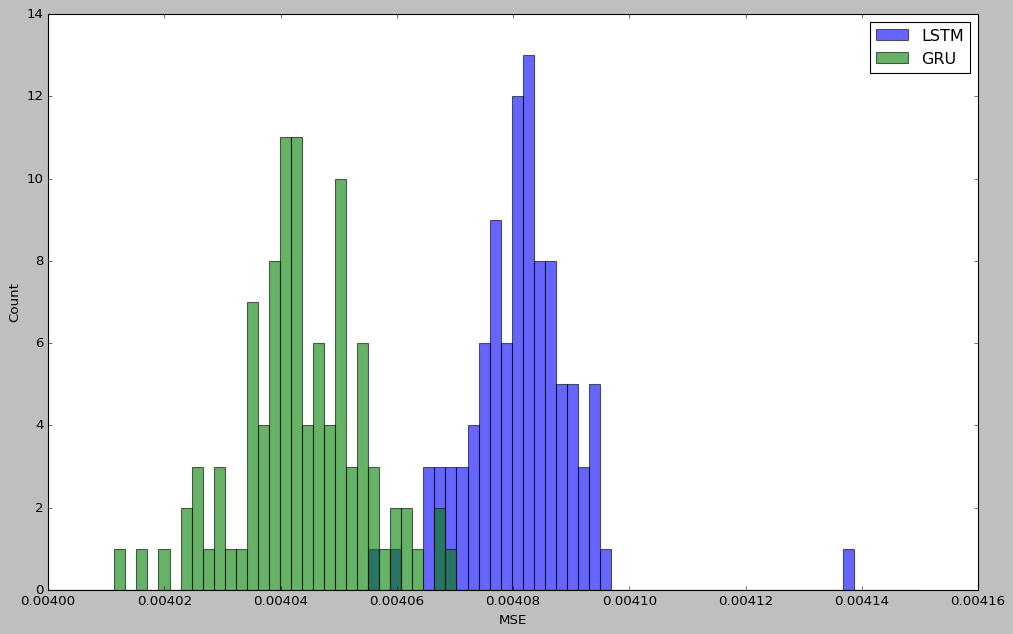

In [31]:
import random
import numpy as np
from matplotlib import pyplot as plt

plt.style.use('classic')

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(15, 9))  # Set figsize

# Plot the histograms
bins = np.linspace(0.004, 0.00415, 80)  # Increase number of bins
ax.hist(result_mse_lstm, bins, alpha=0.6, label='LSTM')  # Adjust alpha value
ax.hist(result_mse_GRU, bins, alpha=0.6, label='GRU')  # Adjust alpha value

# Add labels and title
ax.set_xlabel('MSE')
ax.set_ylabel('Count')

# Add legend
ax.legend(loc='upper right')

# Show the plot
plt.show()


In [42]:
# calculate the mean of the two list and print the result with text: 
mean_mse_lstm = sum(result_mse_lstm) / len(result_mse_lstm)
print("The mean of the LSTM is:", mean_mse_lstm)
mean_mse_GRU = sum(result_mse_GRU) / len(result_mse_GRU)
print("The mean of the GRU is:", mean_mse_GRU)

# calculate the standard deviation of the two list and print the result with text:
std_mse_lstm = np.std(result_mse_lstm)
print("The standard deviation of the LSTM is:", std_mse_lstm)
std_mse_GRU = np.std(result_mse_GRU)
print("The standard deviation of the GRU is:", std_mse_GRU)

The mean of the LSTM is: 0.00408119488568932
The mean of the GRU is: 0.004043513113167208
The standard deviation of the LSTM is: 9.762604179265917e-06
The standard deviation of the GRU is: 1.0807184882732276e-05


## RUN THE LSTM MODEL

/var/folders/73/n7lgj33x23g9bs4jy5z1pgg40000gn/T/ipykernel_4696/2097936497.py:149: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model, epochs=100, batch_size=16, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)], shuffle=False)
2023-04-02 09:47:36.836509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:47:37.025437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:47:37.166706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:47:37.554832: I tensorflow/core/grappler/opt

2/2 [==============================] - 0s 30ms/step - loss: 0.0837


2023-04-02 09:47:42.403382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:47:42.574069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:47:42.710999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:47:43.121869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:47:43.187985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 34ms/step - loss: 0.0643


2023-04-02 09:47:49.128275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:47:49.312369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:47:49.475008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:47:49.992753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:47:50.046296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 33ms/step - loss: 0.0350


2023-04-02 09:47:57.672639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:47:57.831604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:47:57.991696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:47:58.783390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:47:58.845404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Best Score: -0.0610
Best Parameters:  {'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'kernel_regularizer': 0.01, 'num_nodes': 128, 'optimizer': 'rmsprop', 'recurrent_regularizer': 0.001}


2023-04-02 09:48:07.944668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:48:08.155891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:48:08.313729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:48:08.877965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:48:08.938657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test Loss: 0.0248


2023-04-02 09:48:17.162546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:48:17.205862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy: 0.4404
Precision: 0.4407
Recall: 0.4407
Test Loss: 0.02
MSE: 0.004146
Percentage of times y_pred and y_test move in the same direction: 44.04%


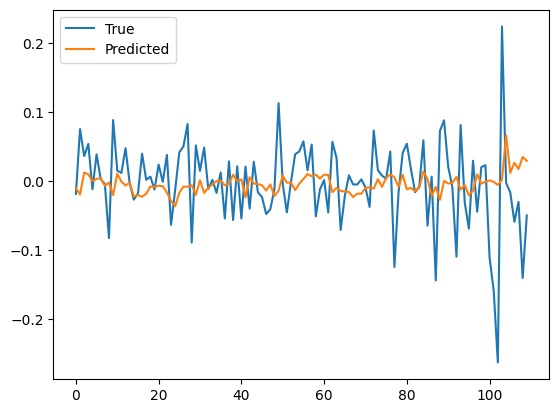

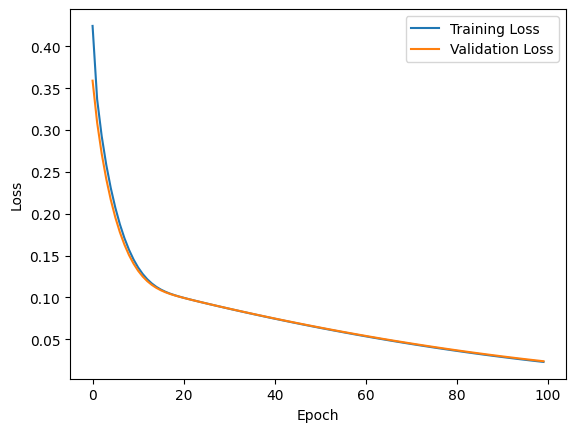

In [16]:
# We wish to first only look at one stock. We wish to find the "best model" for the one stock. 
# Parameters we take into account are: Numbers of lagged values as input (we choose 12), num_nodes, optimizer, batch_size, 3X kernal, dropout, and batch size.
# we will look at exxon corp (permno = 11850)
# First we wish to find the optimal hyperparameters for the model.
# We will use a grid search to find the optimal hyperparameters. (this code will loop though a large grid of parameters and return the best parameters)

import sqlite3
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dropout
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.models import load_model
np.random.seed(33)
tf.random.set_seed(33)

# Connect to SQLite database
conn = sqlite3.connect("/Users/jensknudsen/Desktop/Seminar/tidy_finance_ML.sqlite")

# Create a pandas DataFrame from the "crsp_monthly" table in the SQLite database
crsp_monthly = pd.read_sql_query("SELECT permno, month, ret_excess, mktcap_lag, sic2, macro_dp, macro_bm, macro_ntis, macro_tbl, characteristic_mom1m, characteristic_mvel1, characteristic_mom12m, characteristic_chmom, characteristic_maxret FROM stock_characteristics_monthly", conn)

# define a function to convert the number of days to a datetime object
def convert_days_to_datetime(num_days):
    start_date = datetime.datetime(1960, 1, 1)
    delta = datetime.timedelta(days=num_days)
    return start_date + delta

# apply the function to the 'date' column to convert it to datetime
crsp_monthly['month'] = crsp_monthly['month'].apply(convert_days_to_datetime)
crsp_monthly

# Select only the stocks that have 708 observations
df = crsp_monthly.query('month >= "1960-01-01"') \
                   .groupby('permno') \
                   .filter(lambda x: len(x) >= 611)

# Count the number of unique stocks in the DataFrame
num_stocks = len(df['permno'].unique())

# make a function that findt the first day of the closest month
def get_closest_first_day(date):
    year = date.year
    month = date.month
    day = date.day
    if day > 15:
        if month == 12:
            month = 1
            year += 1
        else:
            month += 1
    return datetime.datetime(year, month, 1)
# apply the get_closest_first_day function to the month column to get the closest first day of the month
df['date'] = df['month'].apply(get_closest_first_day)

# reorder the columns in the dataframe with 'date' as the first column
df = df[['date'] + [ col for col in df.columns if col != 'date' ]]

# reset the index of the dataframe
df = df.reset_index(drop=True)

# change the datatype of permno column to integer
df['permno'] = df['permno'].astype(int)

for e in df['permno'].unique()[len(list_permno_lstm):len(list_permno_lstm)+1]:
    # subset the dataframe for the permno 11850
    df_first = df[df['permno'] == e]
    # drop the columns permno, month, and sic2 from the subsetted dataframe
    df_first = df_first.drop('permno', axis=1)
    df_first = df_first.drop('month', axis=1)
    df_first = df_first.drop('sic2', axis=1)
    # shift all columns from the 4th column onwards by 1 row to create a lag variable
    df_first.iloc[:, 3:] = df_first.iloc[:, 3:].shift(periods=1)
    # remove the first row of the dataframe
    df_first = df_first.iloc[1:]
    # calculate the first difference between each of the rows for all columns from the 3rd column onwards to make the input variables stationary
    df_first.iloc[:, 2:] = df_first.diff().iloc[:, 2:]
    # create a lagged variable for the 'mktcap_lag' column by taking the first difference between each of the rows
    df_first['mktcap_lag'] = df_first['mktcap_lag'].diff()
    # remove the first row of the dataframe
    df_first = df_first.iloc[2:]
    # Check if the data is in the correct format
    if df_first.isnull().values.any():    # Checking if the DataFrame 'df_first' contains any null values
        raise ValueError('Data contains null values')   # Raising an error if the DataFrame contains any null values
    if not all([col in df_first.columns for col in ['date', 'ret_excess']]):   # Checking if the DataFrame 'df_first' contains the required columns
        raise ValueError('Data is not in the correct format. Expected columns: Time, Returns')   # Raising an error if the DataFrame doesn't contain the required columns
    # Preprocess the data
    scaler = StandardScaler()   # Creating a StandardScaler object for scaling the data
    df_first.iloc[:, 2:] = scaler.fit_transform(df_first.iloc[:, 2:])   # Scaling the numerical data in the DataFrame 'df_first'
    X = df_first.iloc[:, 2:].values   # Extracting the feature data from the DataFrame 'df_first'
    y = df_first.iloc[:, 1].values    # Extracting the target data from the DataFrame 'df_first'
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)   # Splitting the data into training and testing sets with a test size of 0.2
    # Reshape the data for LSTM
    # Reshaping the input data to be of shape so that it can be fed into the LSTM model
    lookback_periods = 12
    X_train_list = []
    X_test_list = []
    for i in range(lookback_periods, X_train.shape[0]):
        X_train_list.append(X_train[i-lookback_periods:i, :])
    for i in range(lookback_periods, X_test.shape[0]):
        X_test_list.append(X_test[i-lookback_periods:i, :])
    X_train = np.array(X_train_list)
    X_test = np.array(X_test_list)
    X_train = X_train.reshape(X_train.shape[0], lookback_periods, X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0], lookback_periods, X_test.shape[2])
    y_train = np.delete(y_train, list(range(-1, lookback_periods-1)))
    y_test = np.delete(y_test, list(range(-1, lookback_periods-1)))
        # Define the function to create the LSTM model
    def create_model(num_nodes=128, optimizer='adam', kernel_regularizer=0.001, recurrent_regularizer=0.001, bias_regularizer=0.001, dropout=0.2, batch_size=32):
        model = Sequential()
        # Add an LSTM layer with `num_nodes` number of nodes
        # The `input_shape` argument specifies the shape of the input data
        # The `kernel_regularizer`, `recurrent_regularizer`, and `bias_regularizer` arguments add L2 regularization to the kernel, recurrent, and bias weights of the layer, respectively
        model.add(LSTM(num_nodes, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=tf.keras.regularizers.l2(kernel_regularizer), recurrent_regularizer=tf.keras.regularizers.l2(recurrent_regularizer), bias_regularizer=tf.keras.regularizers.l2(bias_regularizer)))
        # Add a dropout layer to the model
        # The `dropout` argument specifies the rate of neurons to be dropped out during training
        model.add(Dropout(dropout))
        # Add a dense layer with 32 nodes and ReLU activation
        model.add(Dense(32, activation='sigmoid')) # maybe use the default activation function sigmoid instead of relu
        # Add a dense output layer with 1 node
        model.add(Dense(1))
        # Compile the model with the mean squared error loss function and the specified optimizer
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model
    # Define the grid search parameters
    # The `param_grid` dictionary contains the hyperparameters to be searched over in the grid search
    param_grid = {
        'num_nodes': [128],
        'optimizer': ['rmsprop'],
        'kernel_regularizer': [0.01],
        'recurrent_regularizer': [0.001],
        'bias_regularizer': [0.001],
        'dropout': [0.2],
        'batch_size': [64],
    }
    # Create the KerasRegressor object with the specified hyperparameters and settings
    model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model, epochs=100, batch_size=16, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)], shuffle=False)
    # Define the time series cross-validation object with 3 splits
    tscv = TimeSeriesSplit(n_splits=3)
    # Create the GridSearchCV object with the specified hyperparameters and cross-validation object
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv)
    # Fit the GridSearchCV object to the training data to find the best hyperparameters (setting verbose=0 get the output minimized)
    grid_result = grid.fit(X_train, y_train,verbose=0)
    # Print the best score and best parameters found by GridSearchCV
    print('Best Score: {:.4f}'.format(grid_result.best_score_))
    print('Best Parameters: ', grid_result.best_params_)
    # Create a new LSTM model with the best hyperparameters found by GridSearchCV
    best_model = create_model(**grid_result.best_params_)
    # Train the best model on the training data with the same settings as before
    best_history = best_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)], shuffle=False, verbose=0)
    # Evaluate the best model on the test data and print the test loss
    loss = best_model.evaluate(X_test, y_test, verbose=0)
    print('Test Loss: {:.4f}'.format(loss))
    # Use the best model to make predictions on the test data
    y_pred = best_model.predict(X_test, verbose=0)
    # Calculate accuracy, precision, and recall
    y_pred_direction = np.sign(y_pred[1:] - y_pred[:-1])    # Calculate the predicted direction of stock prices
    y_test_direction = np.sign(y_test[1:] - y_test[:-1])    # Calculate the actual direction of stock prices
    accuracy = accuracy_score(y_test_direction, y_pred_direction)    # Calculate the accuracy score
    precision = precision_score(y_test_direction, y_pred_direction, average='macro')    # Calculate the precision score
    recall = recall_score(y_test_direction, y_pred_direction, average='macro')    # Calculate the recall score
    # Print the accuracy, precision, and recall scores
    print('Accuracy: {:.4f}'.format(accuracy))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    # Evaluate the best_model
    loss = best_model.evaluate(X_test, y_test, verbose=0)    # Evaluate the model on the test data
    print('Test Loss: {:.2f}'.format(loss))
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)    # Calculate the mean squared error between the predicted and actual stock prices
    print('MSE: {:.6f}'.format(mse))
    # Calculate the percentage of times y_pred and y_test move in the same direction
    num_same_directions = 0    # Initialize the count for the number of times y_pred and y_test move in the same direction
    num_total_movements = len(y_pred) - 1    # Calculate the total number of stock price movements
    for i in range(1, len(y_pred)):
        if (y_pred[i] - y_pred[i-1]) * (y_test[i] - y_test[i-1]) > 0:
            num_same_directions += 1
    pct_same_directions = num_same_directions / num_total_movements * 100    # Calculate the percentage of times y_pred and y_test move in the same direction
    print("Percentage of times y_pred and y_test move in the same direction: {:.2f}%".format(pct_same_directions))

    # Plot the predictions
    import matplotlib.pyplot as plt
    plt.plot(y_test, label='True')    # Plot the actual stock prices
    plt.plot(y_pred, label='Predicted')    # Plot the predicted stock prices
    plt.legend()    # Add a legend to the plot
    plt.show()    # Show the plot
    # Plot the training and validation loss over time
    plt.plot(best_history.history['loss'], label='Training Loss')    # Plot the training loss
    plt.plot(best_history.history['val_loss'], label='Validation Loss')    # Plot the validation loss
    plt.xlabel('Epoch')    # Add a label to the x-axis
    plt.ylabel('Loss')    # Add a label to the y-axis
    plt.legend()    # Add a legend to the plot
    plt.show()    # Show the plot
    # save model to single file
    #best_model.save('best_lstm_model.h5')
    list_mse_lstm.append(mse)
    list_pred_lstm.append(pct_same_directions)
    list_permno_lstm.append(e)

## RUN THE GRU MODEL

/var/folders/73/n7lgj33x23g9bs4jy5z1pgg40000gn/T/ipykernel_4696/3809242707.py:149: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model, epochs=100, batch_size=16, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)], shuffle=False)
2023-04-02 09:50:17.940596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:50:18.105106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:50:18.301573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:50:18.776281: I tensorflow/core/grappler/opt

2/2 [==============================] - 0s 38ms/step - loss: 0.0047


2023-04-02 09:50:22.713000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:50:22.890901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:50:23.047860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:50:23.663548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:50:23.739414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 36ms/step - loss: 0.0027


2023-04-02 09:50:28.134868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:50:28.303242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:50:28.440430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:50:28.935984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:50:28.987103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 36ms/step - loss: 0.0035


2023-04-02 09:50:33.952821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:50:34.137216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:50:34.279658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:50:34.875615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:50:34.932924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Best Score: -0.0036
Best Parameters:  {'batch_size': 64, 'bias_regularizer': 0.001, 'dropout': 0.2, 'kernel_regularizer': 0.01, 'num_nodes': 128, 'optimizer': 'rmsprop', 'recurrent_regularizer': 0.001}


2023-04-02 09:50:43.148314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:50:43.337413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:50:43.496734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:50:44.161504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:50:44.211758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test Loss: 0.0043


2023-04-02 09:50:48.071560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-02 09:50:48.110146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy: 0.4220
Precision: 0.4219
Recall: 0.4218
Test Loss: 0.00
MSE: 0.004101
Percentage of times y_pred and y_test move in the same direction: 42.20%


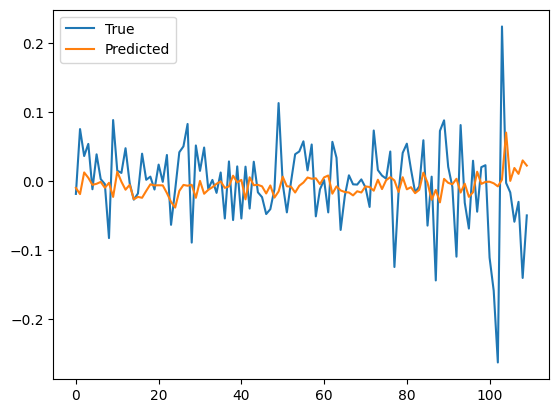

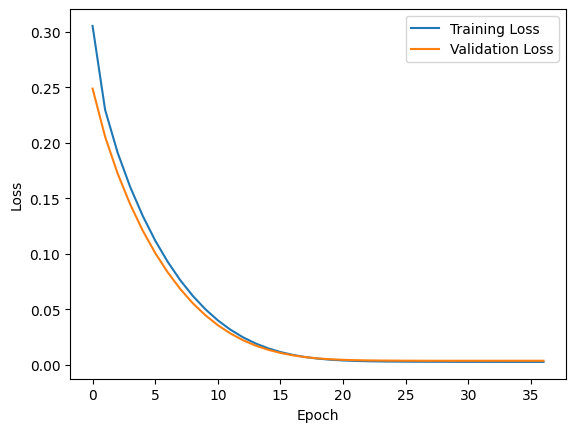

In [17]:
# We wish to first only look at one stock. We wish to find the "best model" for the one stock. 
# Parameters we take into account are: Numbers of lagged values as input (we choose 12), num_nodes, optimizer, batch_size, 3X kernal, dropout, and batch size.
# we will look at exxon corp (permno = 11850)
# First we wish to find the optimal hyperparameters for the model.
# We will use a grid search to find the optimal hyperparameters. (this code will loop though a large grid of parameters and return the best parameters)

import sqlite3
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dropout
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.models import load_model
np.random.seed(33)
tf.random.set_seed(33)

# Connect to SQLite database
conn = sqlite3.connect("/Users/jensknudsen/Desktop/Seminar/tidy_finance_ML.sqlite")

# Create a pandas DataFrame from the "crsp_monthly" table in the SQLite database
crsp_monthly = pd.read_sql_query("SELECT permno, month, ret_excess, mktcap_lag, sic2, macro_dp, macro_bm, macro_ntis, macro_tbl, characteristic_mom1m, characteristic_mvel1, characteristic_mom12m, characteristic_chmom, characteristic_maxret FROM stock_characteristics_monthly", conn)

# define a function to convert the number of days to a datetime object
def convert_days_to_datetime(num_days):
    start_date = datetime.datetime(1960, 1, 1)
    delta = datetime.timedelta(days=num_days)
    return start_date + delta

# apply the function to the 'date' column to convert it to datetime
crsp_monthly['month'] = crsp_monthly['month'].apply(convert_days_to_datetime)
crsp_monthly

# Select only the stocks that have 708 observations
df = crsp_monthly.query('month >= "1960-01-01"') \
                   .groupby('permno') \
                   .filter(lambda x: len(x) >= 611)

# Count the number of unique stocks in the DataFrame
num_stocks = len(df['permno'].unique())

# make a function that findt the first day of the closest month
def get_closest_first_day(date):
    year = date.year
    month = date.month
    day = date.day
    if day > 15:
        if month == 12:
            month = 1
            year += 1
        else:
            month += 1
    return datetime.datetime(year, month, 1)
# apply the get_closest_first_day function to the month column to get the closest first day of the month
df['date'] = df['month'].apply(get_closest_first_day)

# reorder the columns in the dataframe with 'date' as the first column
df = df[['date'] + [ col for col in df.columns if col != 'date' ]]

# reset the index of the dataframe
df = df.reset_index(drop=True)

# change the datatype of permno column to integer
df['permno'] = df['permno'].astype(int)

for e in df['permno'].unique()[len(list_permno_GRU):len(list_permno_GRU)+1]:
    # subset the dataframe for the permno 11850
    df_first = df[df['permno'] == e]
    # drop the columns permno, month, and sic2 from the subsetted dataframe
    df_first = df_first.drop('permno', axis=1)
    df_first = df_first.drop('month', axis=1)
    df_first = df_first.drop('sic2', axis=1)
    # shift all columns from the 4th column onwards by 1 row to create a lag variable
    df_first.iloc[:, 3:] = df_first.iloc[:, 3:].shift(periods=1)
    # remove the first row of the dataframe
    df_first = df_first.iloc[1:]
    # calculate the first difference between each of the rows for all columns from the 3rd column onwards to make the input variables stationary
    df_first.iloc[:, 2:] = df_first.diff().iloc[:, 2:]
    # create a lagged variable for the 'mktcap_lag' column by taking the first difference between each of the rows
    df_first['mktcap_lag'] = df_first['mktcap_lag'].diff()
    # remove the first row of the dataframe
    df_first = df_first.iloc[2:]
    # Check if the data is in the correct format
    if df_first.isnull().values.any():    # Checking if the DataFrame 'df_first' contains any null values
        raise ValueError('Data contains null values')   # Raising an error if the DataFrame contains any null values
    if not all([col in df_first.columns for col in ['date', 'ret_excess']]):   # Checking if the DataFrame 'df_first' contains the required columns
        raise ValueError('Data is not in the correct format. Expected columns: Time, Returns')   # Raising an error if the DataFrame doesn't contain the required columns
    # Preprocess the data
    scaler = StandardScaler()   # Creating a StandardScaler object for scaling the data
    df_first.iloc[:, 2:] = scaler.fit_transform(df_first.iloc[:, 2:])   # Scaling the numerical data in the DataFrame 'df_first'
    X = df_first.iloc[:, 2:].values   # Extracting the feature data from the DataFrame 'df_first'
    y = df_first.iloc[:, 1].values    # Extracting the target data from the DataFrame 'df_first'
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)   # Splitting the data into training and testing sets with a test size of 0.2
    # Reshape the data for GRU
    # Reshaping the input data to be of shape so that it can be fed into the GRU model
    lookback_periods = 12
    X_train_list = []
    X_test_list = []
    for i in range(lookback_periods, X_train.shape[0]):
        X_train_list.append(X_train[i-lookback_periods:i, :])
    for i in range(lookback_periods, X_test.shape[0]):
        X_test_list.append(X_test[i-lookback_periods:i, :])
    X_train = np.array(X_train_list)
    X_test = np.array(X_test_list)
    X_train = X_train.reshape(X_train.shape[0], lookback_periods, X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0], lookback_periods, X_test.shape[2])
    y_train = np.delete(y_train, list(range(-1, lookback_periods-1)))
    y_test = np.delete(y_test, list(range(-1, lookback_periods-1)))
        # Define the function to create the GRU model
    def create_model(num_nodes=128, optimizer='adam', kernel_regularizer=0.001, recurrent_regularizer=0.001, bias_regularizer=0.001, dropout=0.2, batch_size=32):
        model = Sequential()
        # Add an GRU layer with `num_nodes` number of nodes
        # The `input_shape` argument specifies the shape of the input data
        # The `kernel_regularizer`, `recurrent_regularizer`, and `bias_regularizer` arguments add L2 regularization to the kernel, recurrent, and bias weights of the layer, respectively
        model.add(GRU(num_nodes, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=tf.keras.regularizers.l2(kernel_regularizer), recurrent_regularizer=tf.keras.regularizers.l2(recurrent_regularizer), bias_regularizer=tf.keras.regularizers.l2(bias_regularizer)))
        # Add a dropout layer to the model
        # The `dropout` argument specifies the rate of neurons to be dropped out during training
        model.add(Dropout(dropout))
        # Add a dense layer with 32 nodes and ReLU activation
        model.add(Dense(32, activation='sigmoid')) # maybe use the default activation function sigmoid instead of relu
        # Add a dense output layer with 1 node
        model.add(Dense(1))
        # Compile the model with the mean squared error loss function and the specified optimizer
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model
    # Define the grid search parameters
    # The `param_grid` dictionary contains the hyperparameters to be searched over in the grid search
    param_grid = {
        'num_nodes': [128],
        'optimizer': ['rmsprop'],
        'kernel_regularizer': [0.01],
        'recurrent_regularizer': [0.001],
        'bias_regularizer': [0.001],
        'dropout': [0.2],
        'batch_size': [64],
    }
    # Create the KerasRegressor object with the specified hyperparameters and settings
    model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model, epochs=100, batch_size=16, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)], shuffle=False)
    # Define the time series cross-validation object with 3 splits
    tscv = TimeSeriesSplit(n_splits=3)
    # Create the GridSearchCV object with the specified hyperparameters and cross-validation object
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv)
    # Fit the GridSearchCV object to the training data to find the best hyperparameters (setting verbose=0 get the output minimized)
    grid_result = grid.fit(X_train, y_train,verbose=0)
    # Print the best score and best parameters found by GridSearchCV
    print('Best Score: {:.4f}'.format(grid_result.best_score_))
    print('Best Parameters: ', grid_result.best_params_)
    # Create a new GRU model with the best hyperparameters found by GridSearchCV
    best_model = create_model(**grid_result.best_params_)
    # Train the best model on the training data with the same settings as before
    best_history = best_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)], shuffle=False, verbose=0)
    # Evaluate the best model on the test data and print the test loss
    loss = best_model.evaluate(X_test, y_test, verbose=0)
    print('Test Loss: {:.4f}'.format(loss))
    # Use the best model to make predictions on the test data
    y_pred = best_model.predict(X_test, verbose=0)
    # Calculate accuracy, precision, and recall
    y_pred_direction = np.sign(y_pred[1:] - y_pred[:-1])    # Calculate the predicted direction of stock prices
    y_test_direction = np.sign(y_test[1:] - y_test[:-1])    # Calculate the actual direction of stock prices
    accuracy = accuracy_score(y_test_direction, y_pred_direction)    # Calculate the accuracy score
    precision = precision_score(y_test_direction, y_pred_direction, average='macro')    # Calculate the precision score
    recall = recall_score(y_test_direction, y_pred_direction, average='macro')    # Calculate the recall score
    # Print the accuracy, precision, and recall scores
    print('Accuracy: {:.4f}'.format(accuracy))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    # Evaluate the best_model
    loss = best_model.evaluate(X_test, y_test, verbose=0)    # Evaluate the model on the test data
    print('Test Loss: {:.2f}'.format(loss))
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)    # Calculate the mean squared error between the predicted and actual stock prices
    print('MSE: {:.6f}'.format(mse))
    # Calculate the percentage of times y_pred and y_test move in the same direction
    num_same_directions = 0    # Initialize the count for the number of times y_pred and y_test move in the same direction
    num_total_movements = len(y_pred) - 1    # Calculate the total number of stock price movements
    for i in range(1, len(y_pred)):
        if (y_pred[i] - y_pred[i-1]) * (y_test[i] - y_test[i-1]) > 0:
            num_same_directions += 1
    pct_same_directions = num_same_directions / num_total_movements * 100    # Calculate the percentage of times y_pred and y_test move in the same direction
    print("Percentage of times y_pred and y_test move in the same direction: {:.2f}%".format(pct_same_directions))

    # Plot the predictions
    import matplotlib.pyplot as plt
    plt.plot(y_test, label='True')    # Plot the actual stock prices
    plt.plot(y_pred, label='Predicted')    # Plot the predicted stock prices
    plt.legend()    # Add a legend to the plot
    plt.show()    # Show the plot
    # Plot the training and validation loss over time
    plt.plot(best_history.history['loss'], label='Training Loss')    # Plot the training loss
    plt.plot(best_history.history['val_loss'], label='Validation Loss')    # Plot the validation loss
    plt.xlabel('Epoch')    # Add a label to the x-axis
    plt.ylabel('Loss')    # Add a label to the y-axis
    plt.legend()    # Add a legend to the plot
    plt.show()    # Show the plot
    # save model to single file
    #best_model.save('best_GRU_model.h5')
    list_mse_GRU.append(mse)
    list_pred_GRU.append(pct_same_directions)
    list_permno_GRU.append(e)

## Saved results from running the code

In [5]:
list_permno_lstm = [10145, 10516, 10866, 10874, 10890, 11308, 11404, 11674, 11850, 12036, 12052, 12060, 12490, 12570, 12650, 12781, 13303, 13610, 13688, 13856, 13901, 13928, 13936, 14541, 14795, 14816, 15069, 15202, 15456, 15579, 15720, 16432, 16555, 16600, 16678, 17005, 17144, 17478, 17726, 17750, 17830, 17929, 18075, 18091, 18163, 18411, 18438, 18542, 18649, 18729, 19166, 19350, 19393, 19502, 19561, 19721, 20204, 20482, 20618, 20765, 21055, 21135, 21178, 21186, 21207, 21573, 21776, 21792, 21928, 21936, 22103, 22111, 22293, 22509, 22517, 22592, 22752, 22779, 23026, 23229, 23536, 23579, 23712, 23819, 23835, 23931, 24010, 24053, 24109, 24205, 24248, 24272, 24328, 24440, 24459, 24643, 24766, 24969, 24985, 25232, 25304, 25320, 25419, 25582, 25590, 25785, 25953, 26403, 26614, 26710, 26825, 27043, 27334, 27422, 27430, 27633, 27684, 27828, 27887, 27959, 27983, 27991, 28118, 28222, 28345, 28484, 28564, 30680, 31077, 32651, 32678, 32707, 32803, 32870, 33849, 34032, 34497, 34833, 34948, 36003, 36468, 36898, 38156, 38295, 38682, 38703, 38762, 38850, 39490, 39642, 40125, 40272, 40440, 40539, 41080, 41187, 41355, 42059, 42200, 42286, 42550, 42614, 42796, 43123, 43334, 43350, 43449, 43481, 43553, 44134, 44206, 44329, 44601, 44943, 45751, 45911, 46578, 46674, 46690, 46922, 47466, 47511, 47677, 47706, 47730, 47861, 47896, 47941, 48506, 48725, 49015, 49154, 49373, 49656]
list_mse_lstm = [0.00394185548688759, 0.004121473566144685, 0.019940383838445323, 0.011235517237008476, 0.03337138631231098, 0.002439332433517343, 0.0023410996863045936, 0.0021607731254325857, 0.004205192133050115, 0.007397212517889663, 0.003850177398288785, 0.006703784200285408, 0.0037738751793351425, 0.007398807431509365, 0.0066164905061586905, 0.002047754607082293, 0.03681339593111164, 0.010942201333969743, 0.019844661765290282, 0.0021524518711659017, 0.003271296152673286, 0.007221051328230761, 0.012246940743402041, 0.004937074472184425, 0.010806255210051356, 0.0023742676825161506, 0.02439131789822687, 0.006309185158715962, 0.011307891650301757, 0.003826617558726764, 0.0052595395471965725, 0.014439903165730242, 0.006660428256035243, 0.003029679084008799, 0.007297743054281123, 0.005919852826328007, 0.002328752905931587, 0.004614640874723732, 0.005664862789060348, 0.0024387165017237017, 0.0044231129005699605, 0.003588619982860751, 0.021118279070396317, 0.005878207218621105, 0.002090037685178317, 0.0019186691165579276, 0.011354436997469195, 0.0060991567935750005, 0.009831076019025328, 0.002523860206882236, 0.0065221863272233085, 0.005498748058734126, 0.00570222003594232, 0.005648021698649374, 0.009553161012554103, 0.013973585423741722, 0.006421365792770098, 0.003473924110525292, 0.014148255329294387, 0.010992591462172076, 0.018904677702333117, 0.02010712720482369, 0.004534500190102769, 0.006281487719923873, 0.01195672169866174, 0.005961928876076381, 0.0037721071018022244, 0.00385935167587807, 0.0027967001368213503, 0.003339699228616571, 0.004781593362515338, 0.0021858989660523192, 0.005806244091364088, 0.0050221712665128445, 0.003060787379738254, 0.0033584693597339616, 0.0025336507812376797, 0.004413320431314689, 0.0034910786810135506, 0.004311318735212069, 0.0022875319395574837, 0.008356795345235434, 0.0027970937156156484, 0.016786897536077844, 0.003373836052181615, 0.002543383923607021, 0.0032721363148895217, 0.003842931597973171, 0.0028311325228209364, 0.0024388024853679944, 0.0029166903151868796, 0.006320093774126408, 0.020337981438429634, 0.0030546581590565622, 0.02435789676978487, 0.013270415158334086, 0.004482015051521361, 0.004223011369656917, 0.0021215726465199504, 0.014696572896323323, 0.0233729146040676, 0.004230772242968477, 0.012519921269473669, 0.005848520712990473, 0.00436606072851545, 0.0069217512217952, 0.005477869130162392, 0.00641978664077196, 0.0038215103777678194, 0.0025641930648239476, 0.002543892820874164, 0.004462339150647281, 0.005646283615300873, 0.04460163553675124, 0.010059210112944875, 0.011272729283249253, 0.005582410919914682, 0.009449051884417276, 0.0037794793704460654, 0.0026698492556147127, 0.010342679110690433, 0.003401283692404444, 0.01699753130121269, 0.003452944247542906, 0.027081745594664978, 0.013828432010261831, 0.009660200355699158, 0.009777760878560368, 0.0073925290869876386, 0.028978170073255035, 0.0076569085608425924, 0.013850432238953743, 0.01658165277426019, 0.0031121489578721183, 0.011437368374029862, 0.008216301754626228, 0.0037818093310641185, 0.01477605049985885, 0.011588122156288483, 0.004271393195375886, 0.0046451043908182915, 0.005472524416216915, 0.011622950731993095, 0.02012588828723384, 0.029469701210441224, 0.004785679465287027, 0.002875456132679474, 0.049935472367290866, 0.06050954691274156, 0.003446916565656137, 0.018257585568094575, 0.004826747203461816, 0.03999695059753401, 0.004075561428572186, 0.006997570323408787, 0.0019436160660896617, 0.006820944316192352, 0.004457601425798511, 0.005586122756497511, 0.009214794115571039, 0.0059800670132638825, 0.008361621050603351, 0.010312625311418739, 0.02232154286885048, 0.009614753365131524, 0.005626443804590491, 0.003411469374052953, 0.010780391087562728, 0.0070881066659607165, 0.011628430111481439, 0.002809795598048537, 0.004533380985110192, 0.004396249001767302, 0.01676934008872506, 0.002677927953991873, 0.01794415323187515, 0.0029882023357632524, 0.004098391292758521, 0.0086832073862466, 0.03185974436031333, 0.010202522666784996, 0.005127030334763272, 0.022634141828462427, 0.00878147653779718, 0.0052219713678283135, 0.01167731915287504, 0.00723960021500377, 0.008268189157137036, 0.004607353169086526, 0.00451472429009385, 0.012354008220752277, 0.005502639038688128, 0.007413282722476848, 0.0052183433749482065]
list_pred_lstm = [53.21100917431193, 56.88073394495413, 53.21100917431193, 32.11009174311927, 48.62385321100918, 52.293577981651374, 50.45871559633027, 48.62385321100918, 41.284403669724774, 32.11009174311927, 44.95412844036697, 66.05504587155964, 55.96330275229357, 51.37614678899083, 40.36697247706422, 66.05504587155964, 55.04587155963303, 60.550458715596335, 38.53211009174312, 49.54128440366973, 56.88073394495413, 65.13761467889908, 48.62385321100918, 69.72477064220183, 33.94495412844037, 44.95412844036697, 68.80733944954129, 71.55963302752293, 44.03669724770643, 56.88073394495413, 45.87155963302752, 46.788990825688074, 56.88073394495413, 66.05504587155964, 49.54128440366973, 31.19266055045872, 57.798165137614674, 58.71559633027523, 42.201834862385326, 54.12844036697248, 61.46788990825688, 63.30275229357798, 52.293577981651374, 38.53211009174312, 37.61467889908257, 61.46788990825688, 62.38532110091744, 60.550458715596335, 67.88990825688074, 58.71559633027523, 55.04587155963303, 36.69724770642202, 57.798165137614674, 39.44954128440367, 40.36697247706422, 43.11926605504588, 41.284403669724774, 54.12844036697248, 46.788990825688074, 50.45871559633027, 33.02752293577982, 39.44954128440367, 39.44954128440367, 49.54128440366973, 47.706422018348626, 55.96330275229357, 42.201834862385326, 58.71559633027523, 55.04587155963303, 58.71559633027523, 58.71559633027523, 57.798165137614674, 47.706422018348626, 52.293577981651374, 38.53211009174312, 66.97247706422019, 51.37614678899083, 49.54128440366973, 49.54128440366973, 37.61467889908257, 61.46788990825688, 54.12844036697248, 56.88073394495413, 35.77981651376147, 38.53211009174312, 53.21100917431193, 49.54128440366973, 47.706422018348626, 68.80733944954129, 68.80733944954129, 49.54128440366973, 49.54128440366973, 57.798165137614674, 67.88990825688074, 49.54128440366973, 63.30275229357798, 40.36697247706422, 43.11926605504588, 54.12844036697248, 48.62385321100918, 53.21100917431193, 48.62385321100918, 33.02752293577982, 45.87155963302752, 59.63302752293578, 41.284403669724774, 55.04587155963303, 45.87155963302752, 52.293577981651374, 53.21100917431193, 51.37614678899083, 54.12844036697248, 42.201834862385326, 61.46788990825688, 54.12844036697248, 37.61467889908257, 60.550458715596335, 54.12844036697248, 62.38532110091744, 54.12844036697248, 39.44954128440367, 55.96330275229357, 48.62385321100918, 53.21100917431193, 57.798165137614674, 40.36697247706422, 40.36697247706422, 45.87155963302752, 59.63302752293578, 44.95412844036697, 51.37614678899083, 46.788990825688074, 49.54128440366973, 60.550458715596335, 53.21100917431193, 56.88073394495413, 66.05504587155964, 42.201834862385326, 71.55963302752293, 55.96330275229357, 37.61467889908257, 52.293577981651374, 32.11009174311927, 48.62385321100918, 54.12844036697248, 55.96330275229357, 66.05504587155964, 54.12844036697248, 66.05504587155964, 63.30275229357798, 47.706422018348626, 65.13761467889908, 44.03669724770643, 42.201834862385326, 55.96330275229357, 45.87155963302752, 64.22018348623854, 62.38532110091744, 38.53211009174312, 44.03669724770643, 54.12844036697248, 35.77981651376147, 46.788990825688074, 45.87155963302752, 53.21100917431193, 59.63302752293578, 56.88073394495413, 65.13761467889908, 36.69724770642202, 60.550458715596335, 33.02752293577982, 49.54128440366973, 68.80733944954129, 63.30275229357798, 61.46788990825688, 59.63302752293578, 52.293577981651374, 63.30275229357798, 65.13761467889908, 36.69724770642202, 59.63302752293578, 62.38532110091744, 40.36697247706422, 55.96330275229357, 52.293577981651374, 35.77981651376147, 57.798165137614674, 61.46788990825688, 50.45871559633027, 68.80733944954129, 54.12844036697248, 47.706422018348626, 45.87155963302752, 54.12844036697248]
list_permno_GRU = [10145, 10516, 10866, 10874, 10890, 11308, 11404, 11674, 11850, 12036, 12052, 12060, 12490, 12570, 12650, 12781, 13303, 13610, 13688, 13856, 13901, 13928, 13936, 14541, 14795, 14816, 15069, 15202, 15456, 15579, 15720, 16432, 16555, 16600, 16678, 17005, 17144, 17478, 17726, 17750, 17830, 17929, 18075, 18091, 18163, 18411, 18438, 18542, 18649, 18729, 19166, 19350, 19393, 19502, 19561, 19721, 20204, 20482, 20618, 20765, 21055, 21135, 21178, 21186, 21207, 21573, 21776, 21792, 21928, 21936, 22103, 22111, 22293, 22509, 22517, 22592, 22752, 22779, 23026, 23229, 23536, 23579, 23712, 23819, 23835, 23931, 24010, 24053, 24109, 24205, 24248, 24272, 24328, 24440, 24459, 24643, 24766, 24969, 24985, 25232, 25304, 25320, 25419, 25582, 25590, 25785, 25953, 26403, 26614, 26710, 26825, 27043, 27334, 27422, 27430, 27633, 27684, 27828, 27887, 27959, 27983, 27991, 28118, 28222, 28345, 28484, 28564, 30680, 31077, 32651, 32678, 32707, 32803, 32870, 33849, 34032, 34497, 34833, 34948, 36003, 36468, 36898, 38156, 38295, 38682, 38703, 38762, 38850, 39490, 39642, 40125, 40272, 40440, 40539, 41080, 41187, 41355, 42059, 42200, 42286, 42550, 42614, 42796, 43123, 43334, 43350, 43449, 43481, 43553, 44134, 44206, 44329, 44601, 44943, 45751, 45911, 46578, 46674, 46690, 46922, 47466, 47511, 47677, 47706, 47730, 47861, 47896, 47941, 48506, 48725, 49015, 49154, 49373, 49656]
list_mse_GRU = [0.003602735552271748, 0.004850046136561915, 0.019736495943173043, 0.011548019778651383, 0.03238364619619272, 0.0023716744830118795, 0.002601992416029928, 0.002201047334939857, 0.004140495508694721, 0.0076911268026839535, 0.004010338960368401, 0.0066547074661923705, 0.0036764518607410044, 0.007516639528254949, 0.006278870262285686, 0.002075193100203011, 0.03628741903620157, 0.010841142292352793, 0.01977078720285401, 0.002082550988799234, 0.0033558479240421188, 0.00746709263742556, 0.011768112328314893, 0.005224512102259143, 0.01122395481848533, 0.002453563288095772, 0.024069486638640916, 0.006254253743567701, 0.011701918526060002, 0.004209682634496352, 0.005432283771280002, 0.014837275383221053, 0.007129720805266648, 0.003014667162683646, 0.007175728719763752, 0.0057473663227238184, 0.0024298248525988168, 0.006510362931361881, 0.006974404068469526, 0.0025817797051986427, 0.00452451355207057, 0.0035023801341476763, 0.021350303127455738, 0.005859875701984262, 0.0023719200923024183, 0.002166962374829385, 0.01136323402177086, 0.006205639217284594, 0.009861418975504023, 0.0021846209661474793, 0.006277738547186387, 0.005575031836609755, 0.006048139973484981, 0.005997047661886237, 0.00913206317990813, 0.01429323477612066, 0.006295822586381321, 0.0038822484123603863, 0.014561876164950745, 0.010439789939424467, 0.019645417748954157, 0.020510092835395538, 0.005046292740716311, 0.006594578836699607, 0.011770317566577539, 0.0060218443199600395, 0.003925649940537336, 0.004033550412659791, 0.0030768672048062254, 0.0036179576801317315, 0.0049327683443736, 0.0019917493350759038, 0.006149618830117771, 0.0048796520566827, 0.0030322152342291786, 0.003132046083845584, 0.0026323780242091944, 0.005595719968315529, 0.003516148576990184, 0.004150929713213968, 0.002316153050443926, 0.008748792710283343, 0.003078457997610896, 0.017952294042512355, 0.0036056896198213813, 0.0026758208464566636, 0.003389160938996741, 0.003909553403590821, 0.002875188427779244, 0.002465084358599776, 0.003088386837398323, 0.006425071670265069, 0.020407265111517588, 0.003115593699629492, 0.024806765167583997, 0.012358299077839748, 0.004663878562494826, 0.00415897791770644, 0.002298953688386346, 0.014287837071290483, 0.023830485953480827, 0.004415255007327431, 0.012553160777019646, 0.00594407886171683, 0.0044416819429355095, 0.00704506062630958, 0.00620214732976055, 0.005460885337033401, 0.00395011137888754, 0.002788642493523773, 0.0025606421277279312, 0.004649057975858596, 0.005591736273150927, 0.044566404107737684, 0.009954032436373519, 0.012814570431855079, 0.006076943722131631, 0.009308789143654296, 0.0037721472579952055, 0.002577168928373625, 0.010858522121277272, 0.003612083251337784, 0.017790085355321703, 0.00353590337902179, 0.027272449931359615, 0.013530494756989742, 0.010157152055791322, 0.010058744183915207, 0.0076633530362498065, 0.02770382994199026, 0.007874533995425632, 0.014452912146348069, 0.01549736452835896, 0.004358443267180253, 0.011592239919809049, 0.00810775804435346, 0.0037821308785599287, 0.014296042033696568, 0.011450901249876761, 0.004684630244353853, 0.004830791905660067, 0.005447388570276417, 0.011810234919043046, 0.01785413892493336, 0.029748564773257494, 0.004385898638249382, 0.003756525404485792, 0.050045148989131, 0.05977261634704704, 0.0033850700203844407, 0.018104340488306656, 0.0051859960728952974, 0.04012696247197424, 0.0038534137577693355, 0.007574576236994527, 0.002236146006729918, 0.006792283203082191, 0.004687895915636293, 0.005560119849083042, 0.009257910829498363, 0.006162392818532133, 0.0078045621005169135, 0.0107281406744869, 0.02320062839123294, 0.009831861941075479, 0.0062525698393390014, 0.003420530775374442, 0.009728179668300653, 0.005961092860226727, 0.011786622326790171, 0.003669561915233368, 0.004244310113373512, 0.004363321466127611, 0.014035510194299659, 0.002809362684272362, 0.01437937744901703, 0.0029469266527324856, 0.003991105599649077, 0.008704839953805133, 0.032939487776782954, 0.010115194731703116, 0.00515689678101424, 0.02295042636773769, 0.008833731656328316, 0.006431388348168085, 0.01180698751727759, 0.008154780800744298, 0.008541462337325207, 0.004710991013855303, 0.0046880379066569725, 0.012144809393027615, 0.005055396379561305, 0.007981783823095048, 0.004970450354941287]
list_pred_GRU = [64.22018348623854, 60.550458715596335, 49.54128440366973, 30.275229357798167, 48.62385321100918, 49.54128440366973, 49.54128440366973, 48.62385321100918, 44.03669724770643, 30.275229357798167, 42.201834862385326, 63.30275229357798, 57.798165137614674, 57.798165137614674, 40.36697247706422, 65.13761467889908, 54.12844036697248, 59.63302752293578, 42.201834862385326, 52.293577981651374, 58.71559633027523, 66.97247706422019, 49.54128440366973, 66.05504587155964, 34.862385321100916, 46.788990825688074, 66.05504587155964, 68.80733944954129, 42.201834862385326, 57.798165137614674, 45.87155963302752, 44.03669724770643, 46.788990825688074, 62.38532110091744, 51.37614678899083, 30.275229357798167, 53.21100917431193, 62.38532110091744, 50.45871559633027, 46.788990825688074, 62.38532110091744, 64.22018348623854, 55.04587155963303, 33.94495412844037, 39.44954128440367, 57.798165137614674, 60.550458715596335, 58.71559633027523, 64.22018348623854, 59.63302752293578, 56.88073394495413, 29.357798165137616, 57.798165137614674, 36.69724770642202, 41.284403669724774, 39.44954128440367, 34.862385321100916, 54.12844036697248, 46.788990825688074, 52.293577981651374, 35.77981651376147, 39.44954128440367, 38.53211009174312, 45.87155963302752, 47.706422018348626, 55.04587155963303, 42.201834862385326, 54.12844036697248, 52.293577981651374, 55.04587155963303, 54.12844036697248, 60.550458715596335, 48.62385321100918, 52.293577981651374, 39.44954128440367, 66.05504587155964, 53.21100917431193, 48.62385321100918, 53.21100917431193, 43.11926605504588, 60.550458715596335, 56.88073394495413, 54.12844036697248, 37.61467889908257, 38.53211009174312, 50.45871559633027, 50.45871559633027, 51.37614678899083, 57.798165137614674, 66.97247706422019, 44.03669724770643, 55.96330275229357, 53.21100917431193, 66.05504587155964, 48.62385321100918, 65.13761467889908, 39.44954128440367, 41.284403669724774, 50.45871559633027, 51.37614678899083, 55.96330275229357, 46.788990825688074, 33.94495412844037, 45.87155963302752, 55.04587155963303, 39.44954128440367, 44.95412844036697, 48.62385321100918, 49.54128440366973, 52.293577981651374, 52.293577981651374, 50.45871559633027, 35.77981651376147, 59.63302752293578, 55.04587155963303, 36.69724770642202, 55.96330275229357, 53.21100917431193, 62.38532110091744, 55.96330275229357, 38.53211009174312, 55.96330275229357, 44.03669724770643, 60.550458715596335, 56.88073394495413, 44.95412844036697, 43.11926605504588, 41.284403669724774, 59.63302752293578, 52.293577981651374, 53.21100917431193, 45.87155963302752, 50.45871559633027, 58.71559633027523, 51.37614678899083, 49.54128440366973, 63.30275229357798, 41.284403669724774, 73.39449541284404, 57.798165137614674, 39.44954128440367, 52.293577981651374, 33.02752293577982, 49.54128440366973, 43.11926605504588, 55.04587155963303, 66.05504587155964, 48.62385321100918, 66.05504587155964, 57.798165137614674, 54.12844036697248, 58.71559633027523, 44.95412844036697, 44.03669724770643, 53.21100917431193, 48.62385321100918, 62.38532110091744, 56.88073394495413, 40.36697247706422, 43.11926605504588, 53.21100917431193, 36.69724770642202, 44.03669724770643, 48.62385321100918, 51.37614678899083, 57.798165137614674, 57.798165137614674, 66.97247706422019, 38.53211009174312, 57.798165137614674, 33.94495412844037, 54.12844036697248, 64.22018348623854, 64.22018348623854, 63.30275229357798, 55.04587155963303, 51.37614678899083, 63.30275229357798, 63.30275229357798, 36.69724770642202, 61.46788990825688, 61.46788990825688, 41.284403669724774, 55.96330275229357, 49.54128440366973, 37.61467889908257, 55.96330275229357, 56.88073394495413, 46.788990825688074, 66.97247706422019, 55.96330275229357, 46.788990825688074, 44.95412844036697, 55.04587155963303]


## Compare the two models

In [6]:
# make the list to numpy array:
list_permno_GRU = np.array(list_permno_GRU)
list_mse_GRU = np.array(list_mse_GRU)
list_pred_GRU = np.array(list_pred_GRU)

list_permno_lstm = np.array(list_permno_lstm)
list_mse_lstm = np.array(list_mse_lstm)
list_pred_lstm = np.array(list_pred_lstm)
import numpy as np

# count number of times a has a lower value than b
LSTM_lower = np.sum(list_mse_lstm < list_mse_GRU)

# count number of times b has a lower value than a
GRU_lower = np.sum(list_mse_GRU < list_mse_lstm)

# print result
if LSTM_lower > GRU_lower:
    print("Array LSTM has more lower values than array GRU.")
elif GRU_lower > LSTM_lower:
    print("Array GRU has more lower values than array LSTM.")
else:
    print("Both arrays have the same number of lower values.")


Array LSTM has more lower values than array GRU.


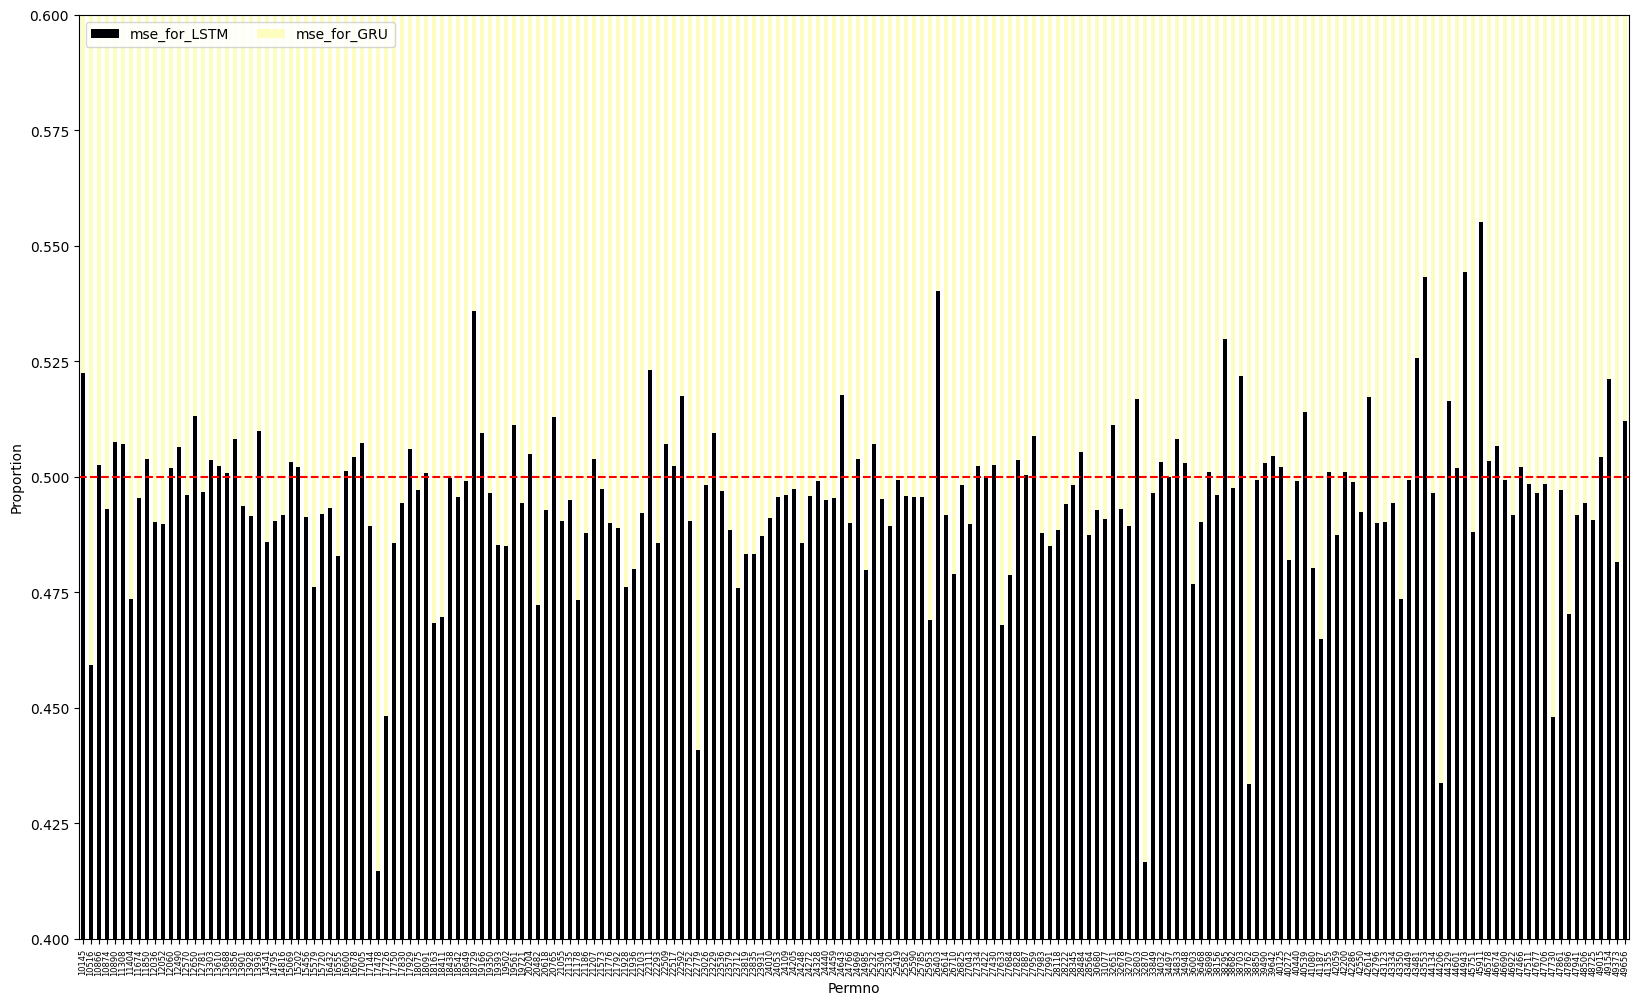

In [7]:
# Make a dataframe with the distribution of the MSE for each permno:
df_mse = pd.DataFrame({'permno': list_permno_GRU, 'mse_GRU': list_mse_GRU, 'mse_lstm': list_mse_lstm})
df_mse['mse_for_LSTM'] = df_mse['mse_lstm']/(df_mse['mse_GRU']+df_mse['mse_lstm'])
df_mse['mse_for_GRU'] = df_mse['mse_GRU']/(df_mse['mse_GRU']+df_mse['mse_lstm'])
# delete the mse_lstm and mse_GRU columns:
df_mse = df_mse.drop(['mse_GRU', 'mse_lstm'], axis=1)
# make the permno the index:
df_mse = df_mse.set_index('permno')

# plot the data
ax = df_mse.plot(kind='bar', 
                    stacked=True, 
                    colormap='magma', 
                    figsize=(20, 12))

# set the y-axis limits to show only the interval between 0.4 and 0.6
ax.set_ylim([0.4, 0.6])

# add a horizontal line at y=0.5
ax.axhline(y=0.5, color='red', linestyle='--')

plt.xticks(fontsize=6)
plt.legend(loc="upper left", ncol=2)
plt.xlabel("Permno")
plt.ylabel("Proportion")
plt.show()


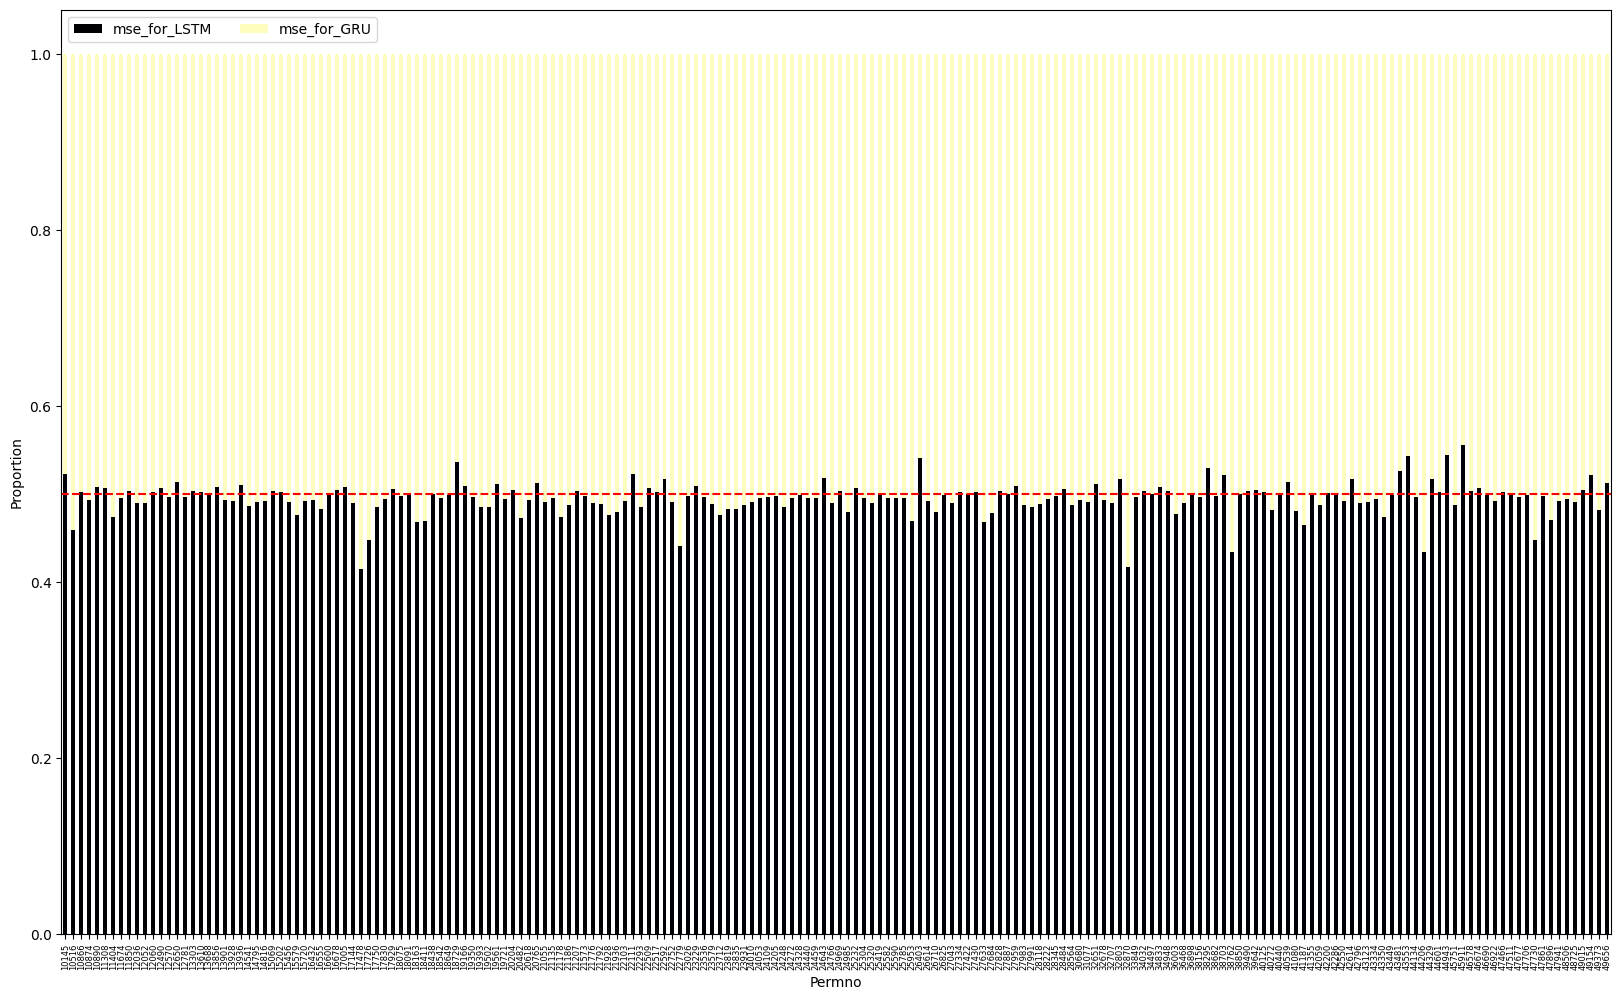

In [8]:
# Make a dataframe with the distribution of the MSE for each permno:
df_mse = pd.DataFrame({'permno': list_permno_GRU, 'mse_GRU': list_mse_GRU, 'mse_lstm': list_mse_lstm})
df_mse['mse_for_LSTM'] = df_mse['mse_lstm']/(df_mse['mse_GRU']+df_mse['mse_lstm'])
df_mse['mse_for_GRU'] = df_mse['mse_GRU']/(df_mse['mse_GRU']+df_mse['mse_lstm'])
# delete the mse_lstm and mse_GRU columns:
df_mse = df_mse.drop(['mse_GRU', 'mse_lstm'], axis=1)
# make the permno the index:
df_mse = df_mse.set_index('permno')

# plot the data
ax = df_mse.plot(kind='bar', 
                    stacked=True, 
                    colormap='magma', 
                    figsize=(20, 12))

# set the y-axis limits to show only the interval between 0.4 and 0.6
#ax.set_ylim([0.4, 0.6])

# add a horizontal line at y=0.5
ax.axhline(y=0.5, color='red', linestyle='--')

plt.xticks(fontsize=6)
plt.legend(loc="upper left", ncol=2)
plt.xlabel("Permno")
plt.ylabel("Proportion")
plt.show()

In [9]:
LSTM_lower

125

In [10]:
GRU_lower

69

In [11]:
LSTM_lower/(LSTM_lower+GRU_lower)*100

64.43298969072166

In [12]:
GRU_lower/(LSTM_lower+GRU_lower)*100

35.56701030927835

In [23]:
# find the mean of list_pred_GRU and list_pred_lstm:
mean_pred_GRU = np.mean(list_pred_GRU, axis=0)
mean_pred_lstm = np.mean(list_pred_lstm, axis=0)

# make a print statement that says this is the mean of the predictions in one line:
print("The mean of the predictions for the GRU is: ", mean_pred_GRU, " and the mean of the predictions for the LSTM is: ", mean_pred_lstm)


The mean of the predictions for the GRU is:  51.24373403953466  and the mean of the predictions for the LSTM is:  51.85850751915255
